In [53]:
import csv
import pandas as pd
import numpy as np
from tqdm import tqdm

In [54]:
# 讀csv，回傳data frame
def DataLoader(file_name):
    df=pd.read_csv(file_name)
    print(df.shape)
    print(df.columns)
    # print("Time:\n")
    # print(df['Time'].describe())
    # print("Amount:\n")
    # print(df['Amount'].describe())
    # print("Class:\n")
    # print(df['Class'].describe())
    # print(df['Class'].value_counts())
    # print(df)
    return df

In [55]:

df=DataLoader('creditcard.csv')


(284807, 31)
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [56]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

In [57]:
# 10:1的資料
def data_sampling(df):
    # print(df)
    fraud_data=df[df['Class']==1]
    normal_data=df[df['Class']==0].sample(n=len(fraud_data)*10,random_state=42)
    # print(fraud_data.shape)
    # print(normal_data.shape)
    selected_df=pd.concat([normal_data,fraud_data])
    selected_df.reset_index(drop=True,inplace=True)
    return selected_df

In [58]:
df=data_sampling(df)
print(df.index)

RangeIndex(start=0, stop=5412, step=1)


In [59]:
# 標準化
def data_standardization(df):
    # 假設 df 是你的 DataFrame，columns 是要標準化的欄位名稱列表
    columns_to_normalize = ['Time', 'Amount']  # 填入要標準化的欄位名稱
    # 初始化 StandardScaler 物件
    scaler = StandardScaler()
    # 對指定列進行標準化
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
    return df



In [60]:
df=data_standardization(df)

In [61]:
def calculate_cosine_similarity(df):
    features=df.drop("Class",axis=1)
    cos_sim=cosine_similarity(features)
    np.save("cos_sim.npy",cos_sim)
    print("Cosine similarity calculation completed and saved.") 

In [62]:
cos_sim=np.load("cos_sim.npy")
print(cos_sim)
print(cos_sim.shape)

[[ 1.         -0.10474847 -0.17063587 ...  0.00880987  0.19544622
   0.52532881]
 [-0.10474847  1.          0.35448425 ... -0.07256405 -0.13313727
  -0.33534979]
 [-0.17063587  0.35448425  1.         ... -0.11640662 -0.14318716
  -0.26465308]
 ...
 [ 0.00880987 -0.07256405 -0.11640662 ...  1.          0.89628544
   0.18719061]
 [ 0.19544622 -0.13313727 -0.14318716 ...  0.89628544  1.
   0.22006893]
 [ 0.52532881 -0.33534979 -0.26465308 ...  0.18719061  0.22006893
   1.        ]]
(5412, 5412)


In [63]:
def cos_sim_describe(cos_sim):
    # 計算每一列的統計量
    max_values = np.max(cos_sim, axis=1)
    min_values = np.min(cos_sim, axis=1)
    median_values = np.median(cos_sim, axis=1)
    mean_values = np.mean(cos_sim, axis=1)
    std_values = np.std(cos_sim, axis=1)

    # 對這些統計量再次計算統計量
    stats_max = np.max(max_values)
    stats_min = np.min(min_values)
    stats_median = np.median(median_values)
    stats_mean = np.mean(mean_values)
    stats_std = np.std(std_values)

    # 印出結果
    print("Statistics of row statistics:")
    print("  Max:", stats_max)
    print("  Min:", stats_min)
    print("  Median:", stats_median)
    print("  Mean:", stats_mean)
    print("  Std:", stats_std)
    cos_sim_dict={'max':stats_max,'min':stats_min,'median':stats_median
                  ,'mean':stats_mean,'std':stats_std}
    return cos_sim_dict

In [64]:
cos_sim_dict=cos_sim_describe(cos_sim)
print(cos_sim_dict)

Statistics of row statistics:
  Max: 1.000000000000001
  Min: -0.8610622522995957
  Median: -0.020403275449845982
  Mean: 0.007676525874176422
  Std: 0.031593458544467296
{'max': 1.000000000000001, 'min': -0.8610622522995957, 'median': -0.020403275449845982, 'mean': 0.007676525874176422, 'std': 0.031593458544467296}


In [65]:
## graph construction
import networkx as nx

In [66]:
def graph_construction(cos_sim,df,threshold):
    G=nx.Graph()
    for i in tqdm(range(cos_sim.shape[0]),desc="Add nodes into G..."):
        node_name=i
        feature=(df.iloc[i]).to_dict()
        G.add_node(node_name,**feature)

    for i in tqdm(range(cos_sim.shape[0]),desc="Graph Construction..."):
        for j in range(i+1,cos_sim.shape[1]):
            if cos_sim[i,j]>threshold:
                G.add_edge(i,j)
    return G


In [67]:
from collections import Counter
def graph_describe(G,round_digit):
    # print("Number of nodes:",G.number_of_nodes())
    # print("Number of edges:",G.number_of_edges())
    density=2*G.number_of_edges()/(G.number_of_nodes()*(G.number_of_nodes()-1))
    # print(f"density = {round(density,round_digit)}")
    # print("Degree:")
    # 获取节点的度数
    degrees = [degree for node, degree in G.degree()]
    # 计算统计指标
    mean_degree = np.mean(degrees)
    median_degree = np.median(degrees)
    std_degree = np.std(degrees)
    max_degree = np.max(degrees)
    min_degree = np.min(degrees)
    # # 打印结果
    # print("Mean Degree:", round(mean_degree,round_digit))
    # print("Median Degree:", round(median_degree,round_digit))
    # print("Standard Deviation of Degree:", round(std_degree,round_digit))
    # print("Max Degree:", round(max_degree,round_digit))
    # print("Min Degree:", round(min_degree,round_digit))

    edge_consistency={}
    fraud_node_set=set()
    for edge in tqdm(G.edges(),desc="Check edge consistent..."):
        node1_class=G.nodes[edge[0]]['Class']
        node2_class=G.nodes[edge[1]]['Class']

        if node1_class==node2_class:
            edge_consistency[edge]=1
        else:
            edge_consistency[edge]=0

    value_counts=Counter(edge_consistency.values())
    # print(value_counts)
    ratio=value_counts[0]/G.number_of_edges()
    # print(f"The ratio of heterogeneous edges is:{round(ratio,round_digit)}")
    return G.number_of_nodes(),G.number_of_edges(),density,mean_degree,median_degree,std_degree,max_degree,min_degree,ratio

In [69]:
import pickle

def save_graph(name, G):
    # save graph object to file
    pickle.dump(G, open("graph/"+name+'.pickle', 'wb'))

def load_graph(name, G):
    # load graph object from file
    G = pickle.load(open("graph/"+name+'.pickle', 'rb'))
    return G

In [70]:
data_dic={'threshold':[],'number_of_nodes':[],'number_of_edges':[],'density':[]
          ,'mean_degree':[],'median_degree':[],'std_of_degree':[],'max_degree':[]
          ,'min_degree':[],'ratio_of_heterogeneous':[]}
graph=[]
for factor in range(31):
    # threshold
    threshold=cos_sim_dict['median']+factor*cos_sim_dict['std']
    data_dic['threshold'].append(threshold)
    G=graph_construction(cos_sim,df,threshold)
    graph.append(G)
    # 存graph
    save_graph(str(threshold), G)
    
    non,noe,d,meand,medd,stdd,maxd,mind,ratio=graph_describe(G,3)
    data_dic['number_of_nodes'].append(non)
    data_dic['number_of_edges'].append(noe)
    data_dic['density'].append(d)
    data_dic['mean_degree'].append(meand)
    data_dic['median_degree'].append(medd)
    data_dic['std_of_degree'].append(stdd)
    data_dic['max_degree'].append(maxd)
    data_dic['min_degree'].append(mind)
    data_dic['ratio_of_heterogeneous'].append(ratio)



Check edge consistent...: 100%|██████████| 14967/14967 [00:00<00:00, 887019.56it/s]


In [71]:
# 存成data.json
import json
for key in data_dic:
    if isinstance(data_dic[key][0], np.int32) or isinstance(data_dic[key][0], np.int64):
        data_dic[key]=[int(num) for num in data_dic[key]]
    elif isinstance(data_dic[key][0], np.float64):
        data_dic[key]=[float(num) for num in data_dic[key]]
json_data=json.dumps(data_dic,indent=4)
with open('data.json','w') as json_file:
    json_file.write(json_data)
with open("data.json",'r') as json_file:
    data_dic=json.load(json_file)
type_list=[]
for key in data_dic:
    print(f"{key}:")
    print([round(num,3) for num in data_dic[key]])
    print(f"type:{type(data_dic[key][0])}")
    type_list.append(type(data_dic[key][0]))
    print()
print(type_list)

threshold:
[-0.02, 0.011, 0.043, 0.074, 0.106, 0.138, 0.169, 0.201, 0.232, 0.264, 0.296, 0.327, 0.359, 0.39, 0.422, 0.453, 0.485, 0.517, 0.548, 0.58, 0.611, 0.643, 0.675, 0.706, 0.738, 0.769, 0.801, 0.833, 0.864, 0.896, 0.927]
type:<class 'float'>

number_of_nodes:
[5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412, 5412]
type:<class 'int'>

number_of_edges:
[7214068, 6344668, 5579009, 4902005, 4301888, 3769543, 3295381, 2871974, 2495539, 2159647, 1861323, 1597259, 1365082, 1161080, 983682, 829075, 695099, 579985, 480836, 395915, 324153, 263023, 211632, 168895, 134227, 105258, 81237, 60284, 42856, 27601, 14967]
type:<class 'int'>

density:
[0.493, 0.433, 0.381, 0.335, 0.294, 0.257, 0.225, 0.196, 0.17, 0.147, 0.127, 0.109, 0.093, 0.079, 0.067, 0.057, 0.047, 0.04, 0.033, 0.027, 0.022, 0.018, 0.014, 0.012, 0.009, 0.007, 0.006, 0.004, 0.003, 0.002, 0.001]
type:<c

plot...: 0it [00:00, ?it/s]/tmp/ipykernel_70787/3776892845.py:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  subset_nodes = random.sample(G.nodes(), k=30)
plot...: 20it [00:08,  4.49it/s]/tmp/ipykernel_70787/3776892845.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 8))
plot...: 31it [00:10,  3.03it/s]


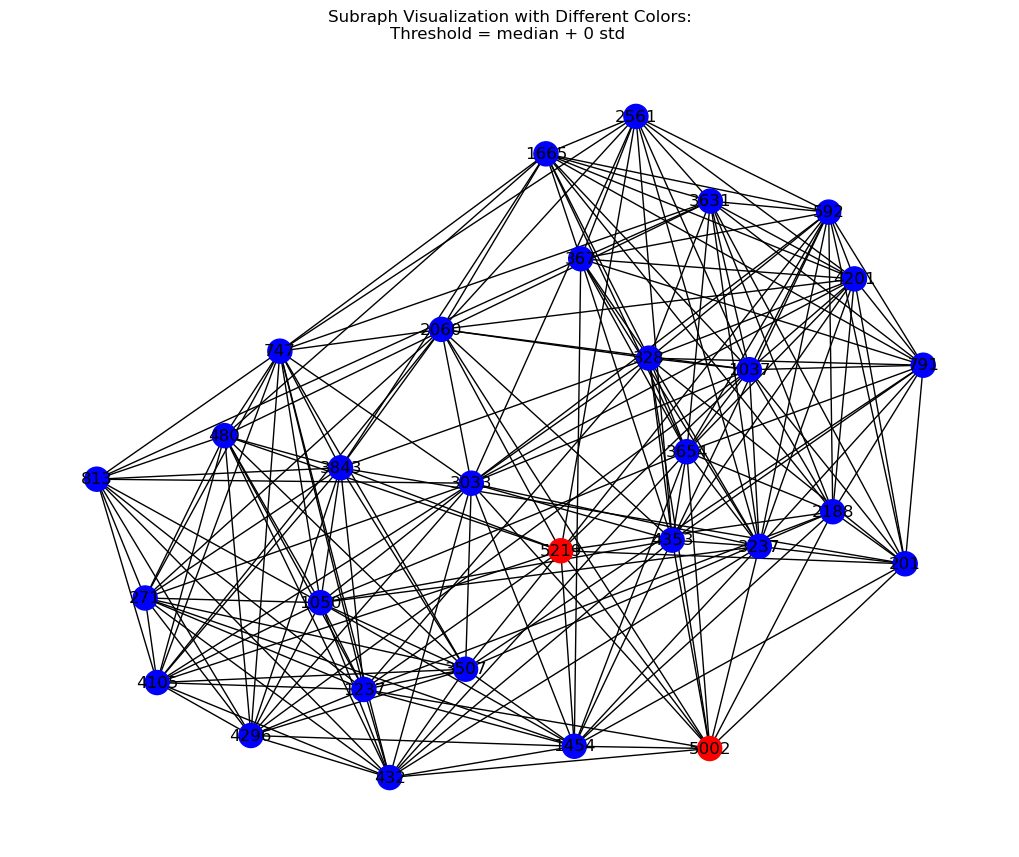

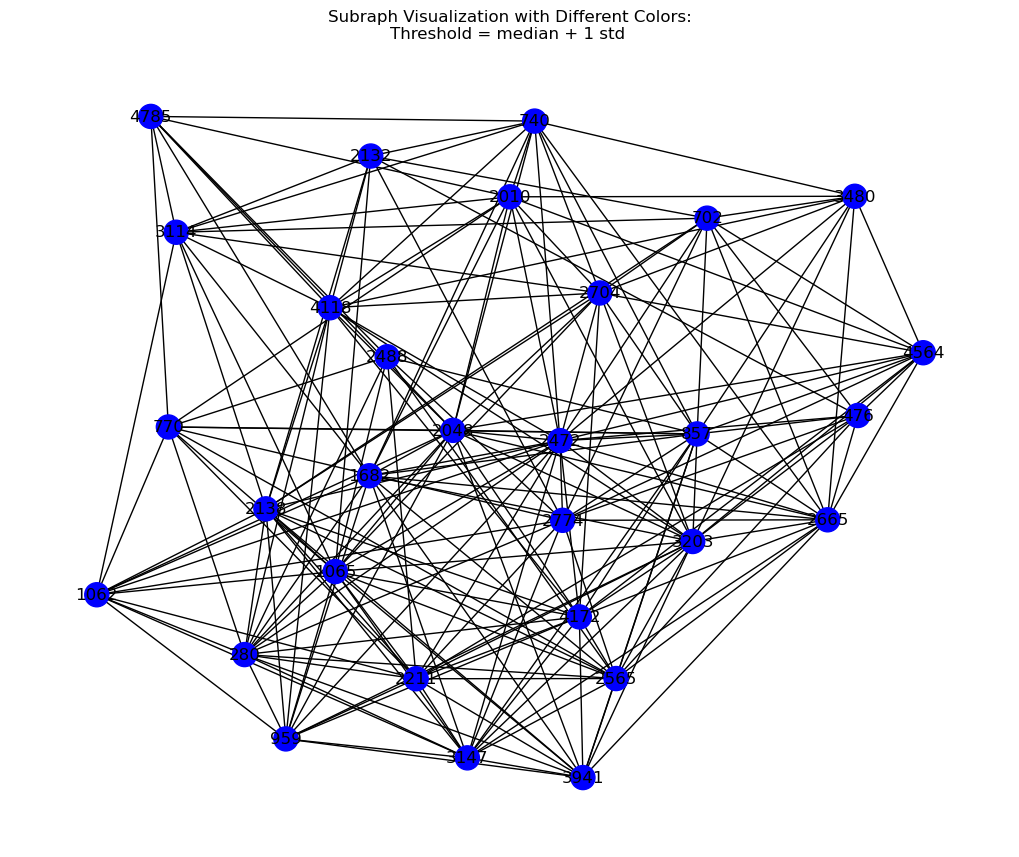

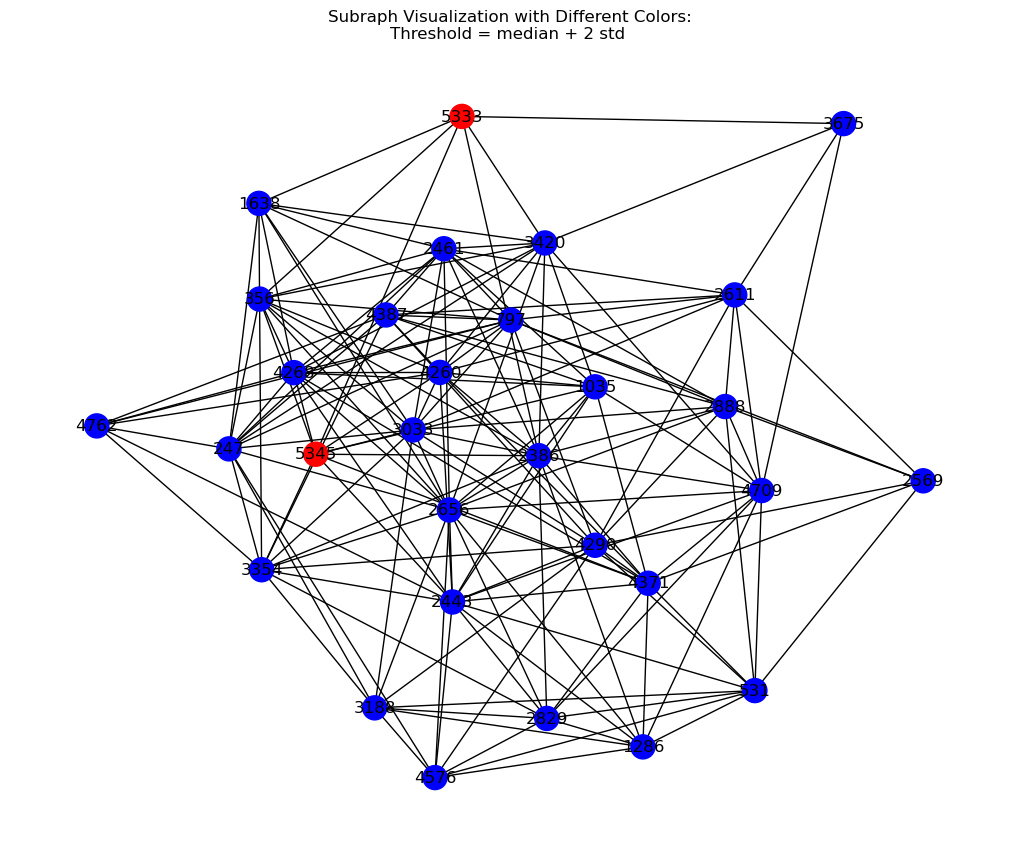

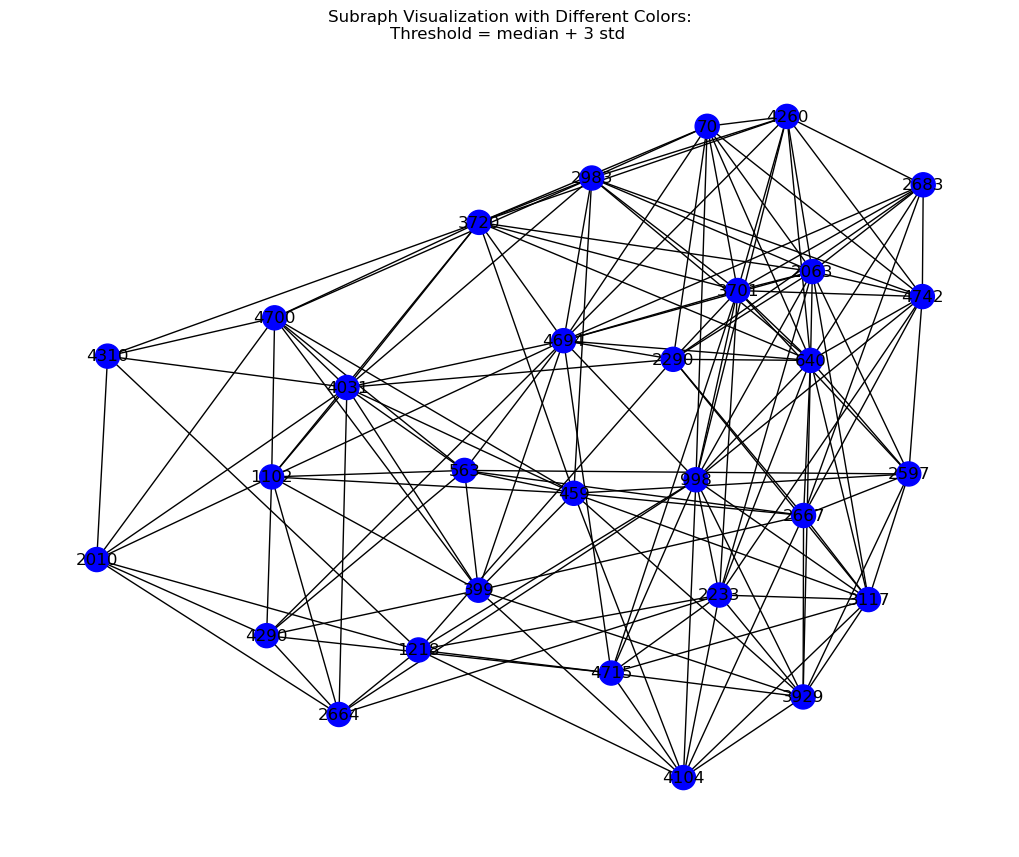

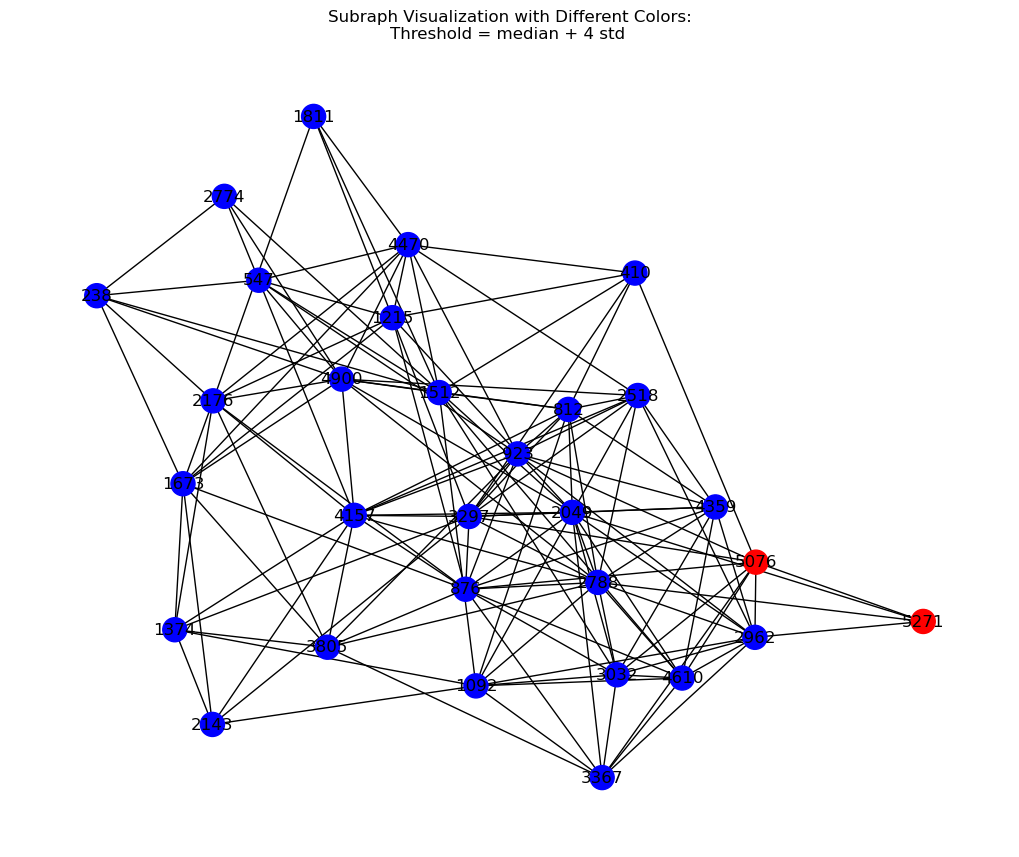

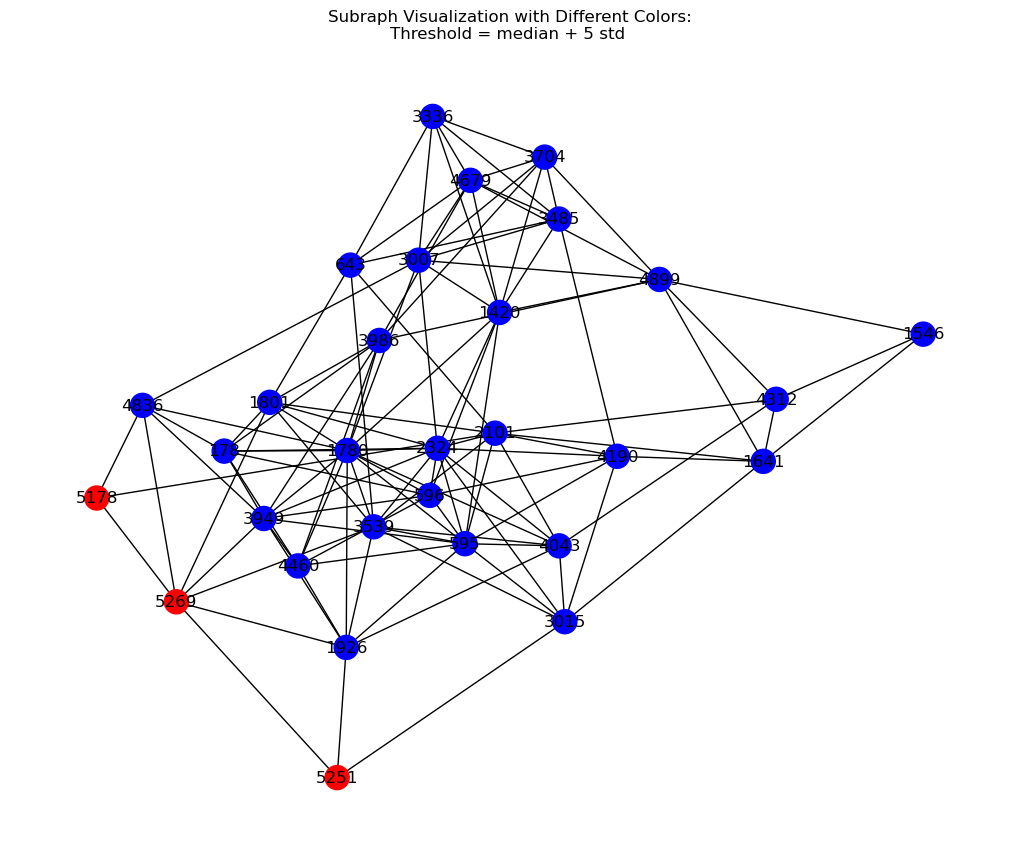

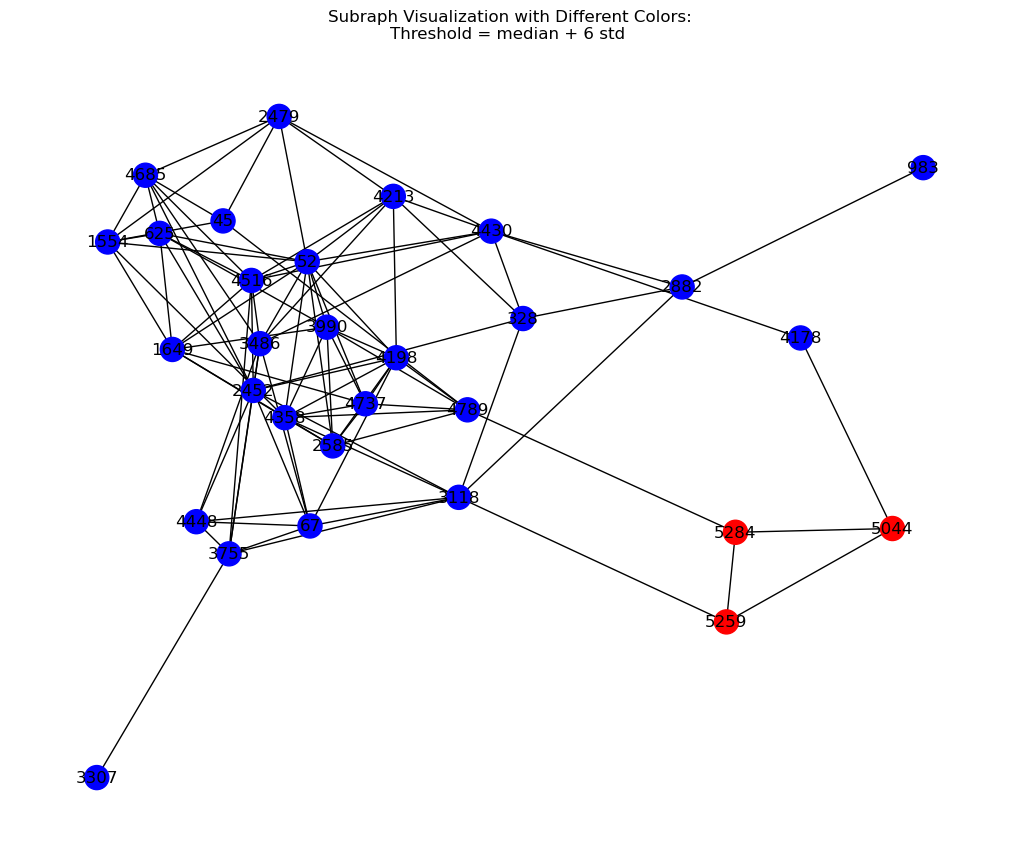

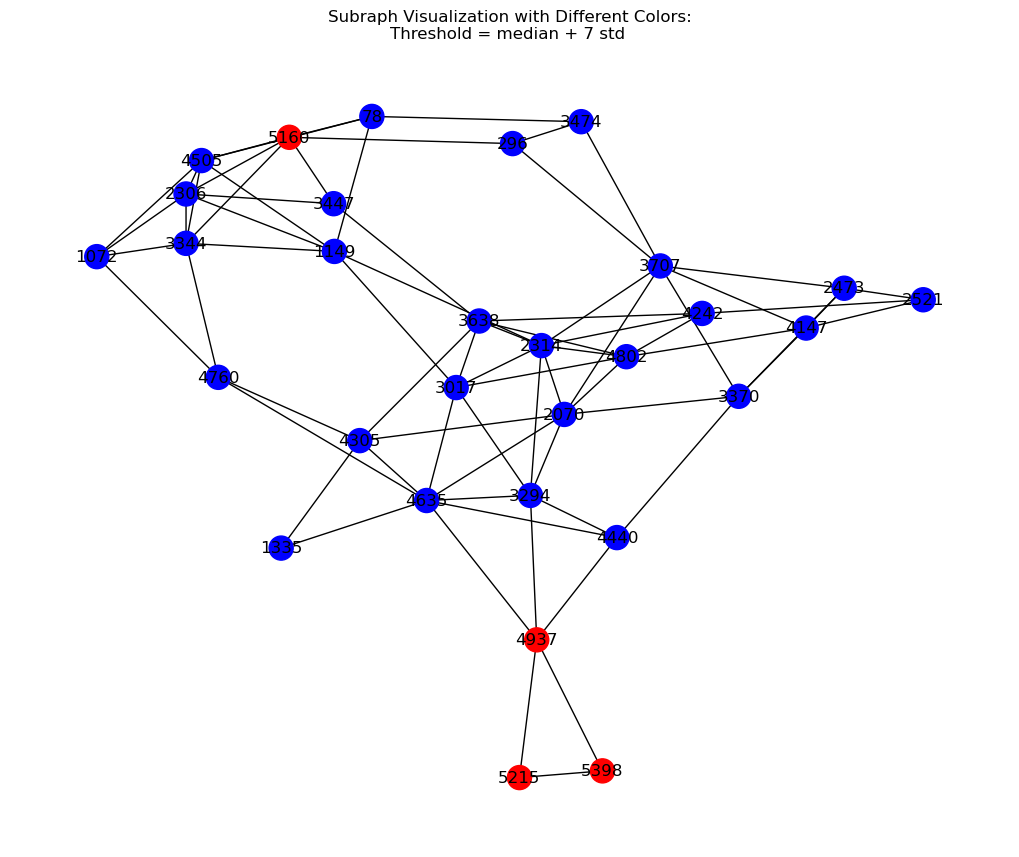

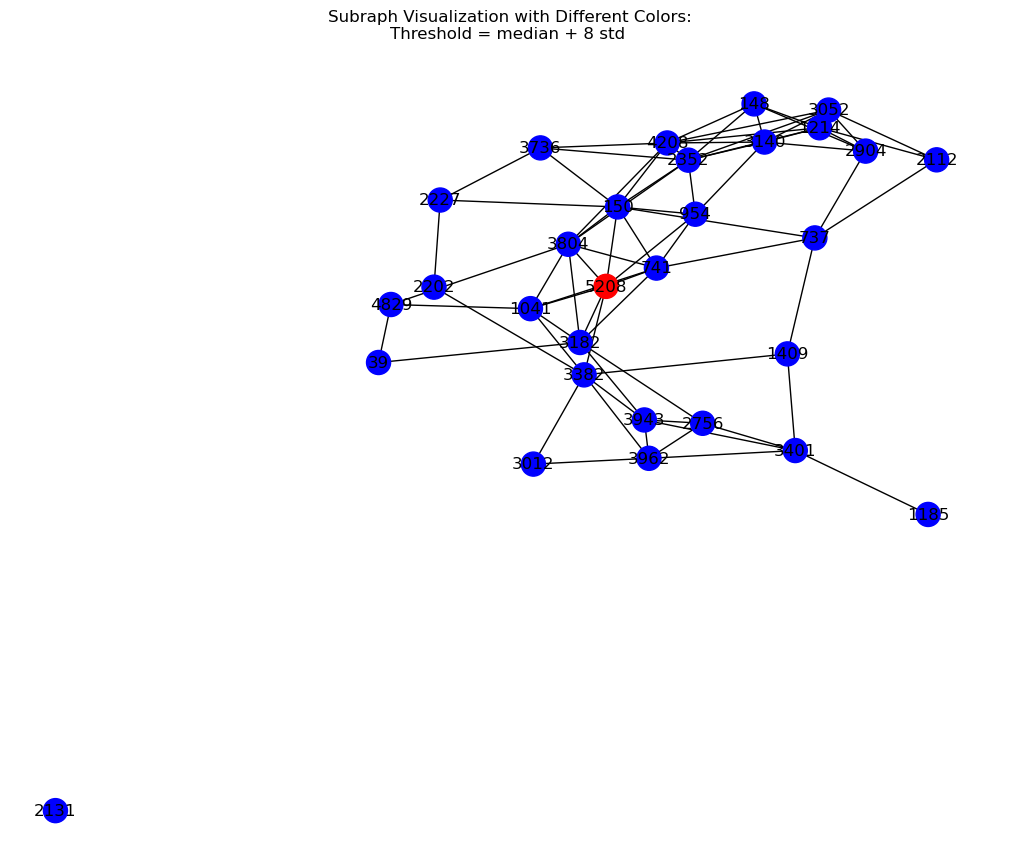

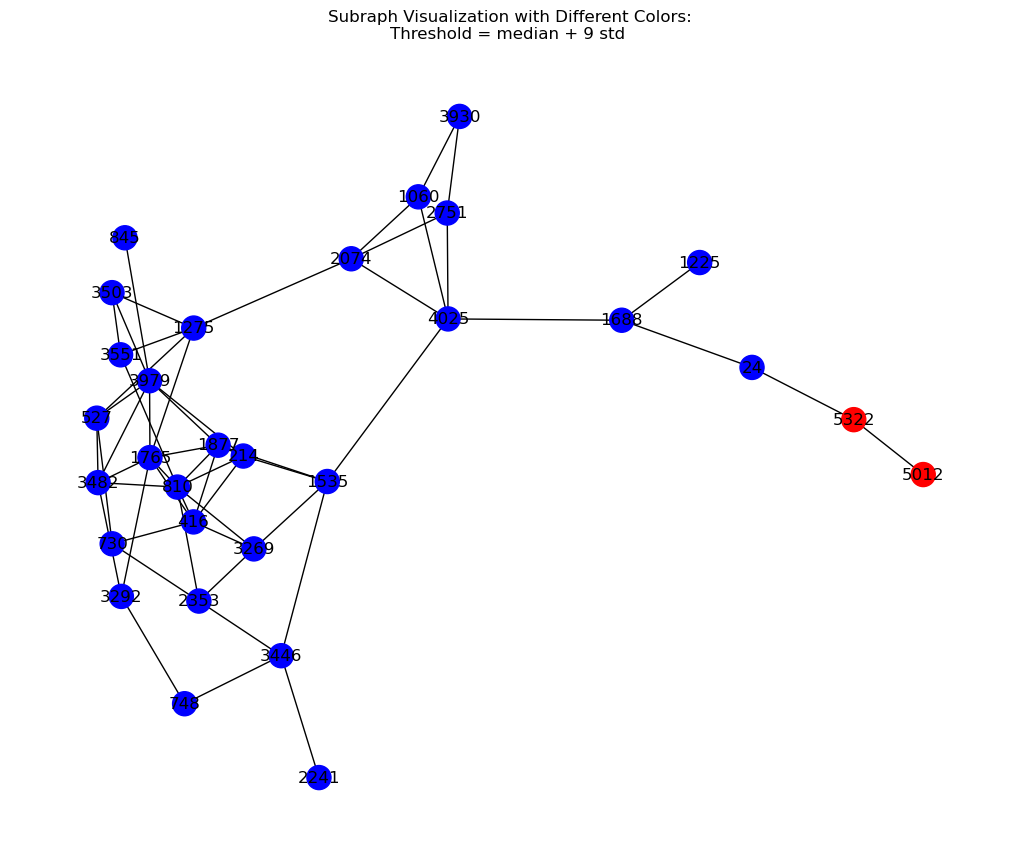

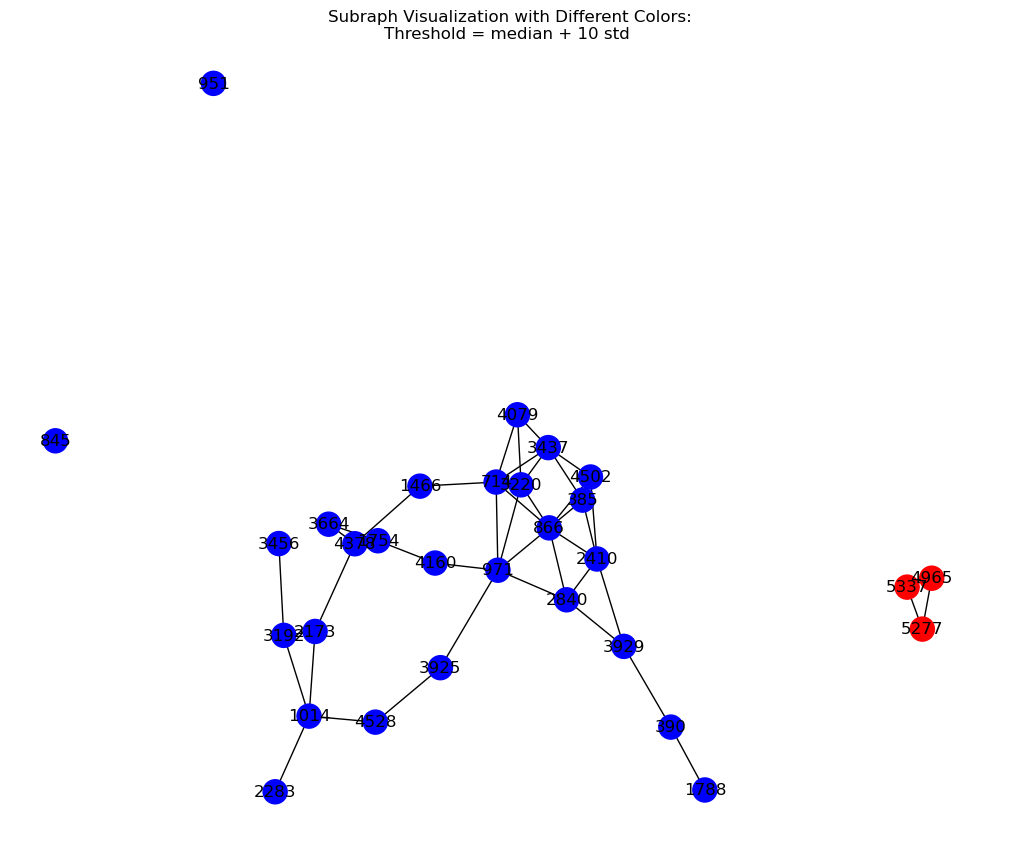

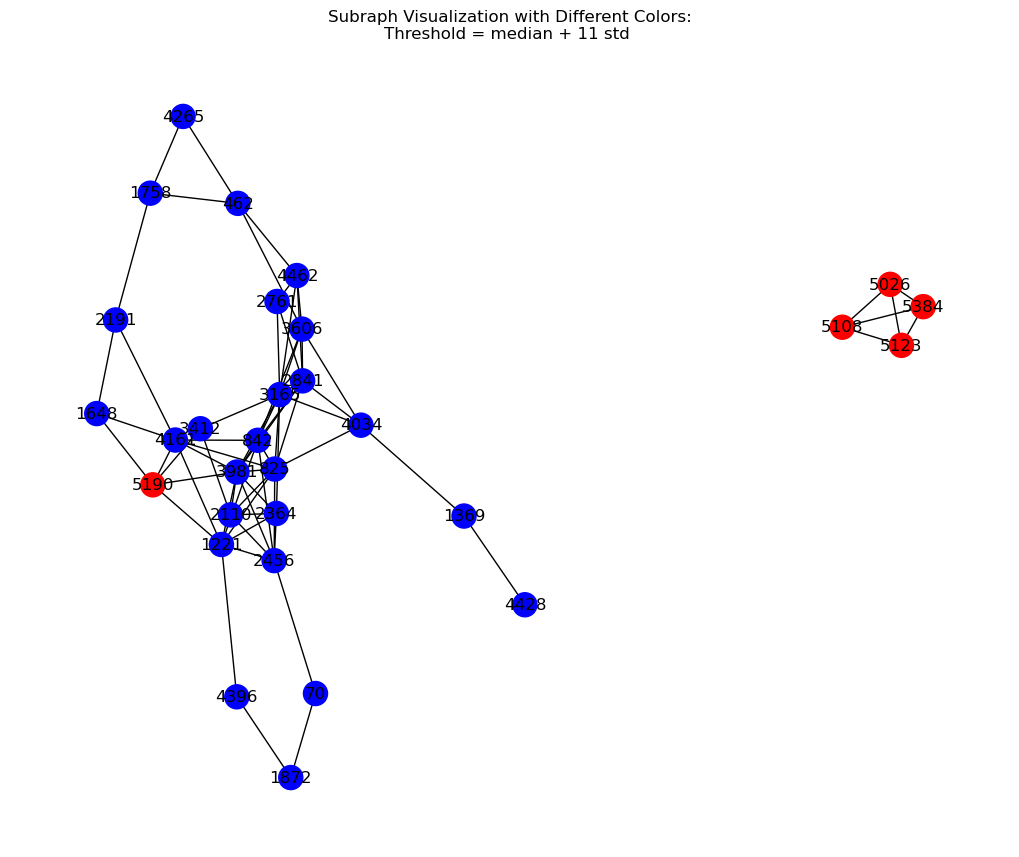

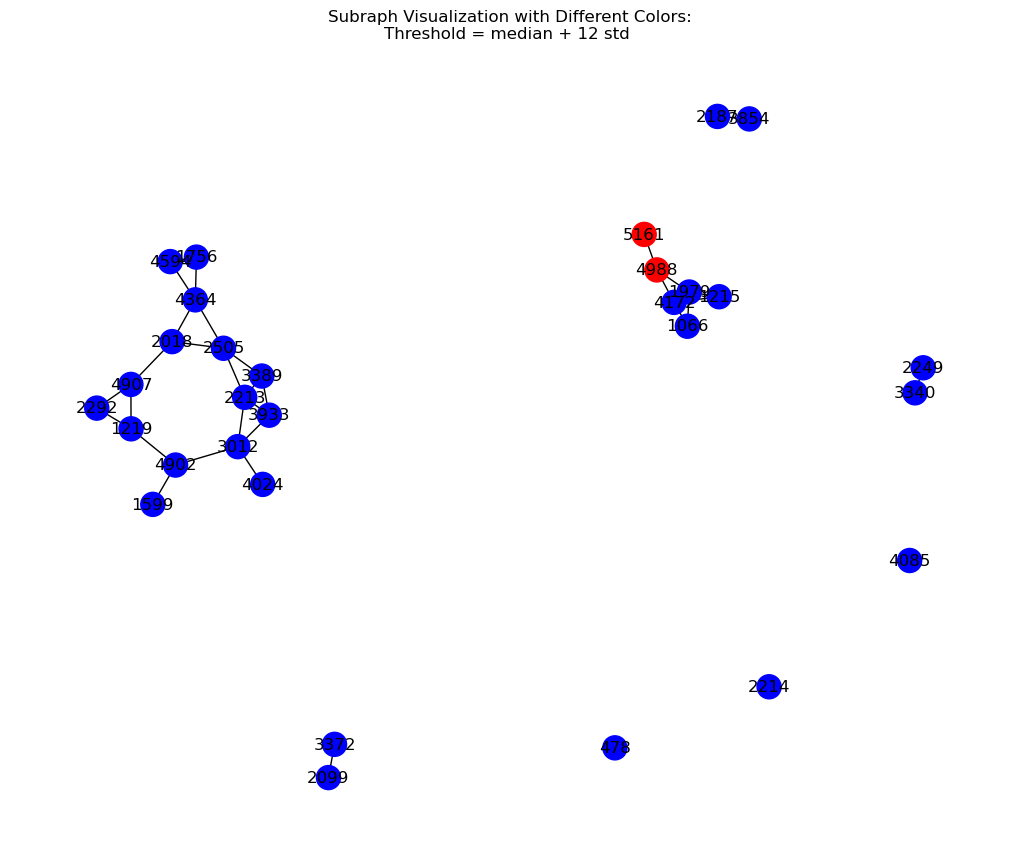

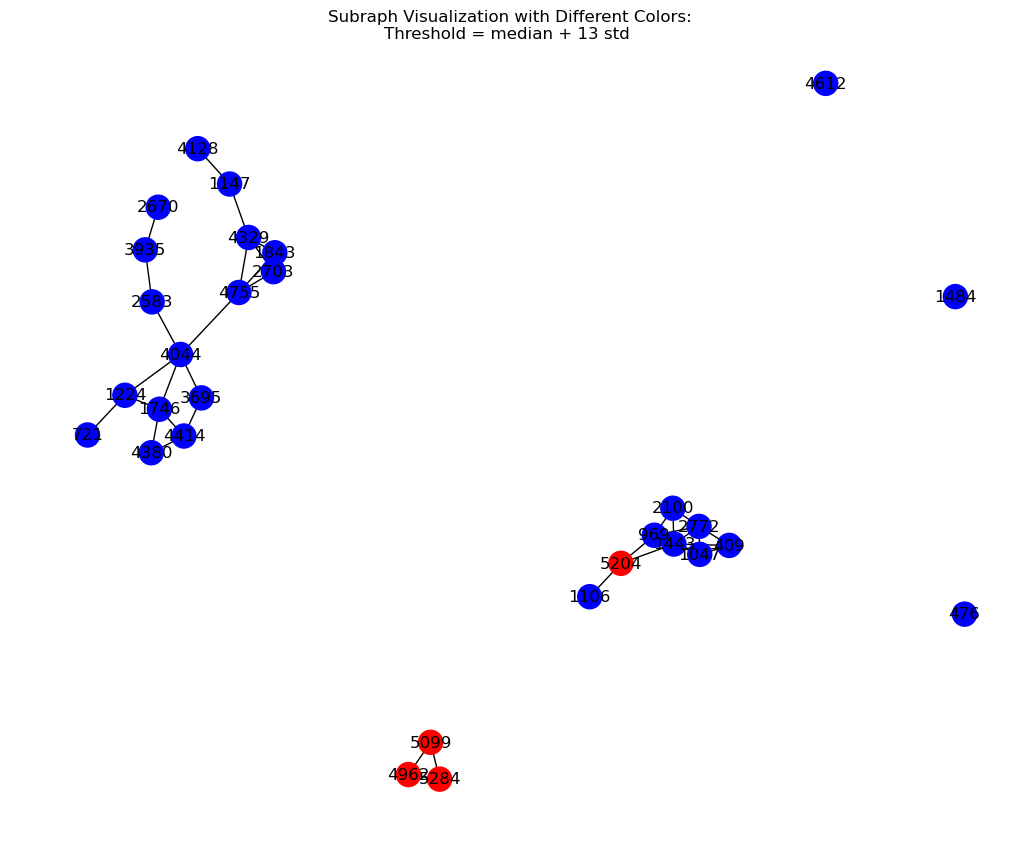

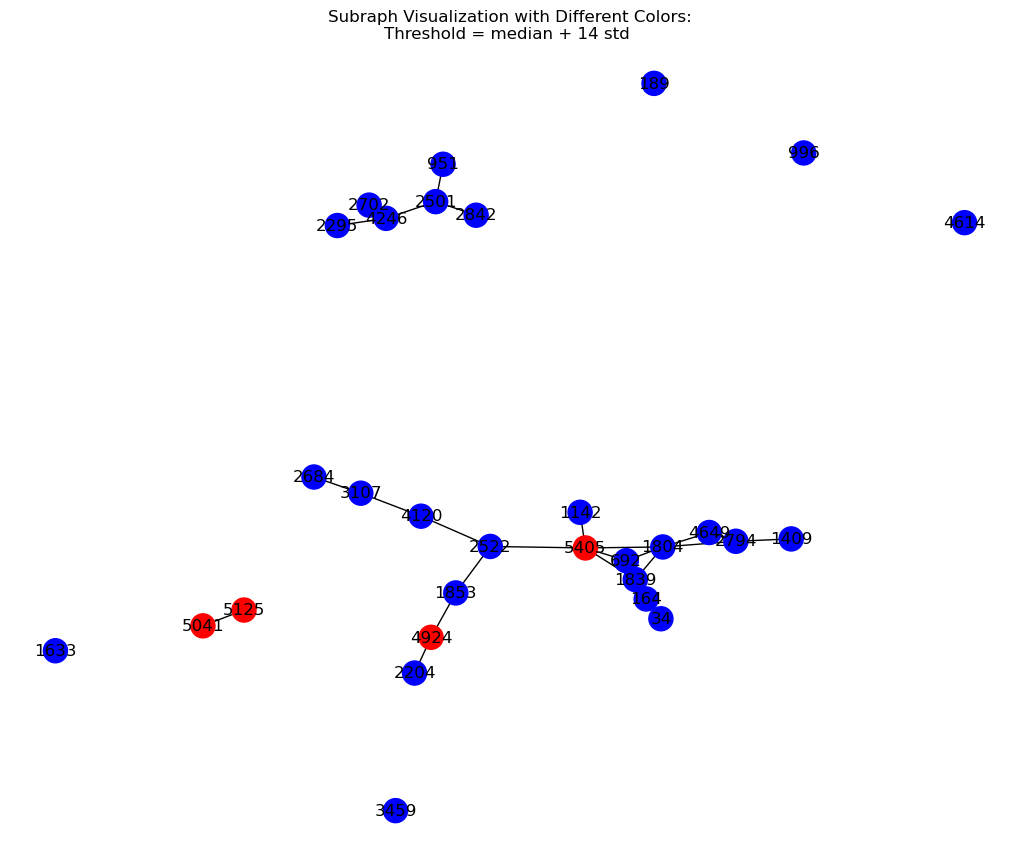

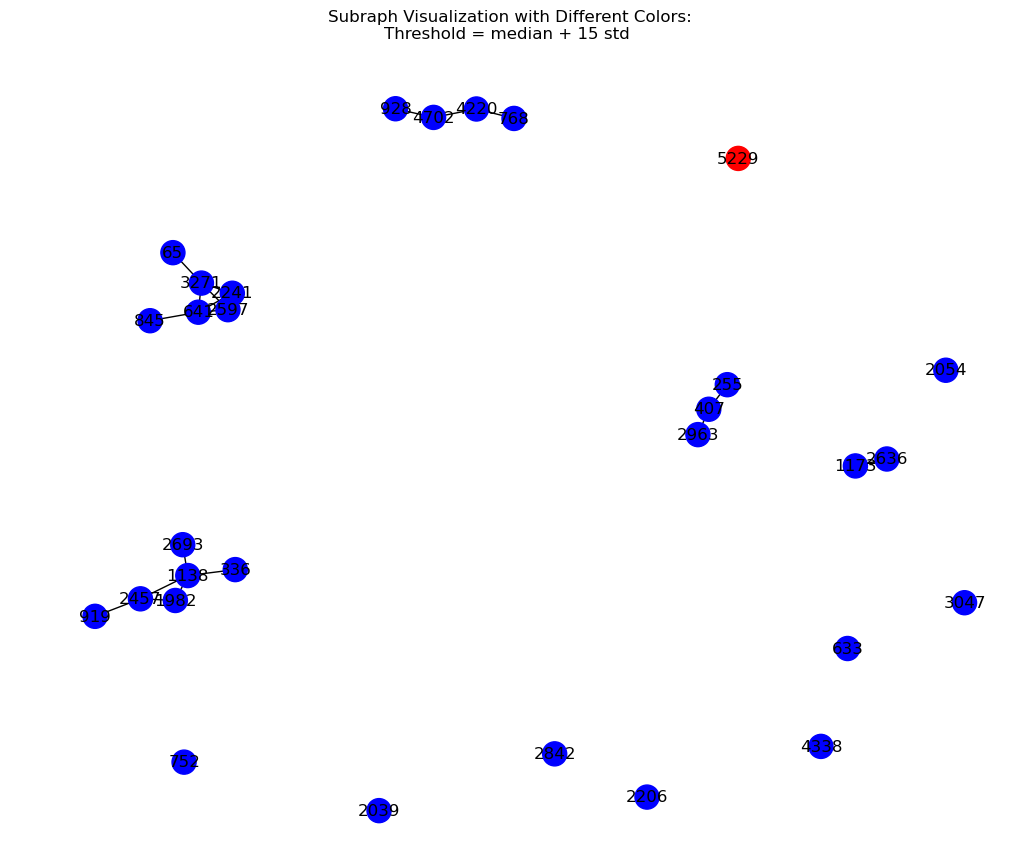

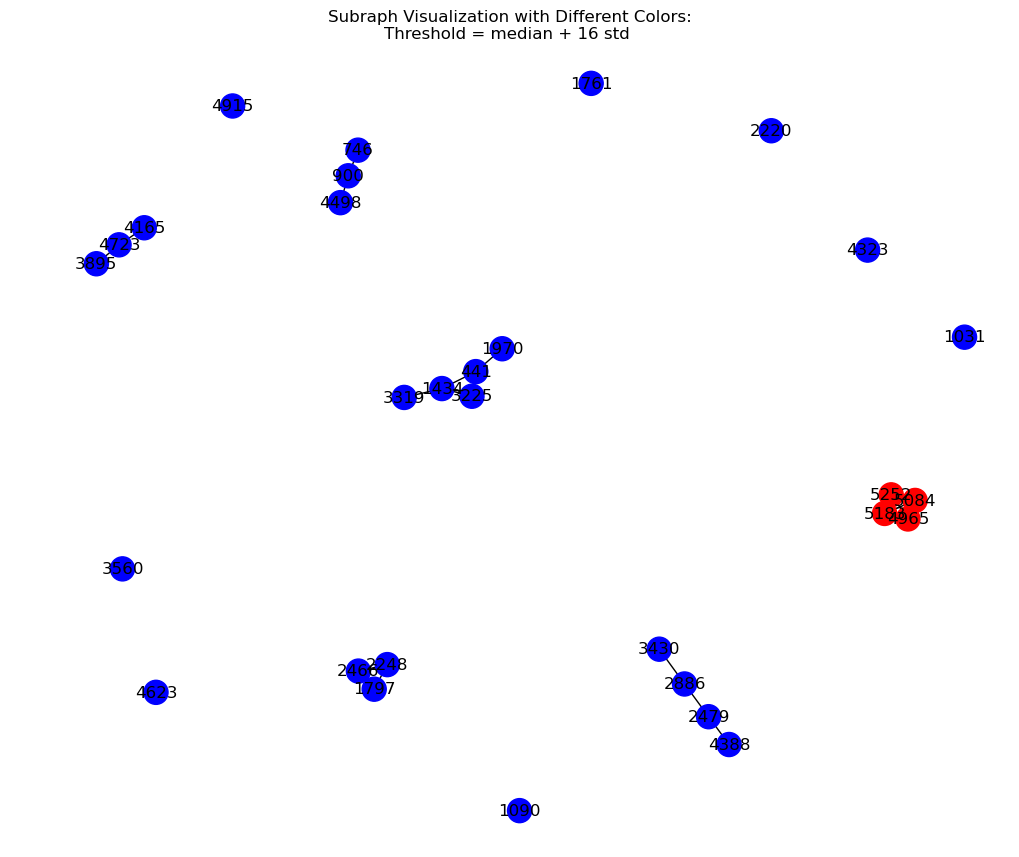

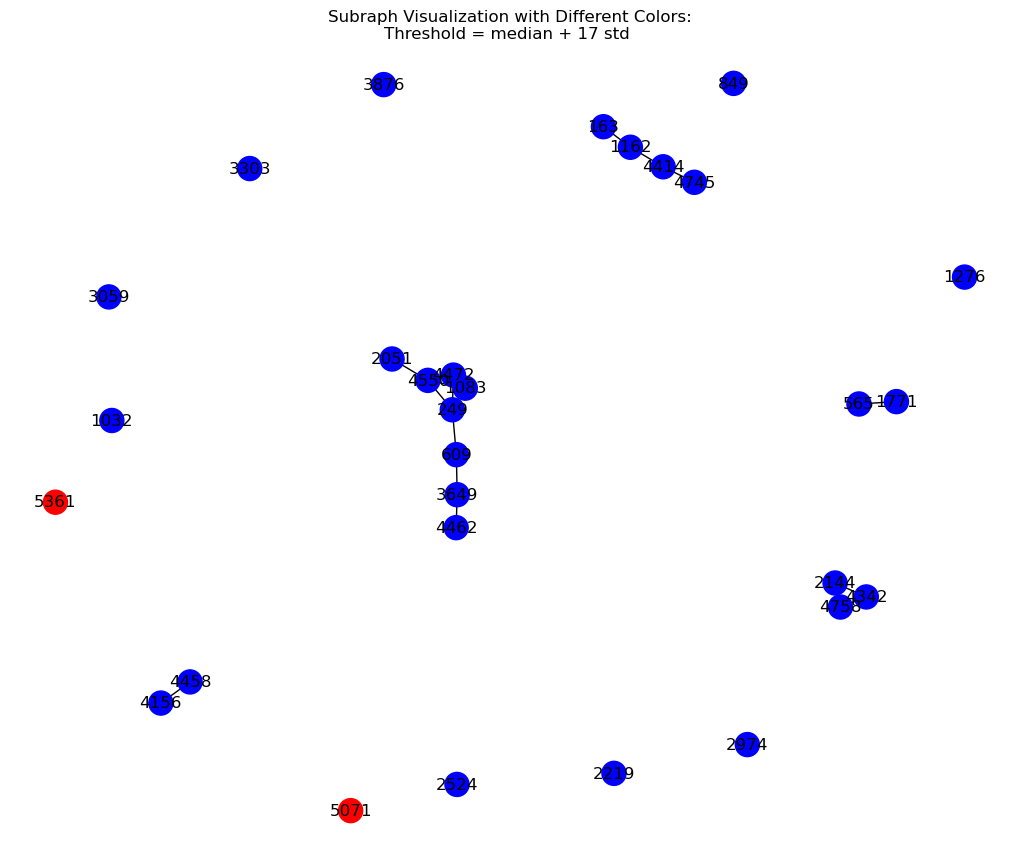

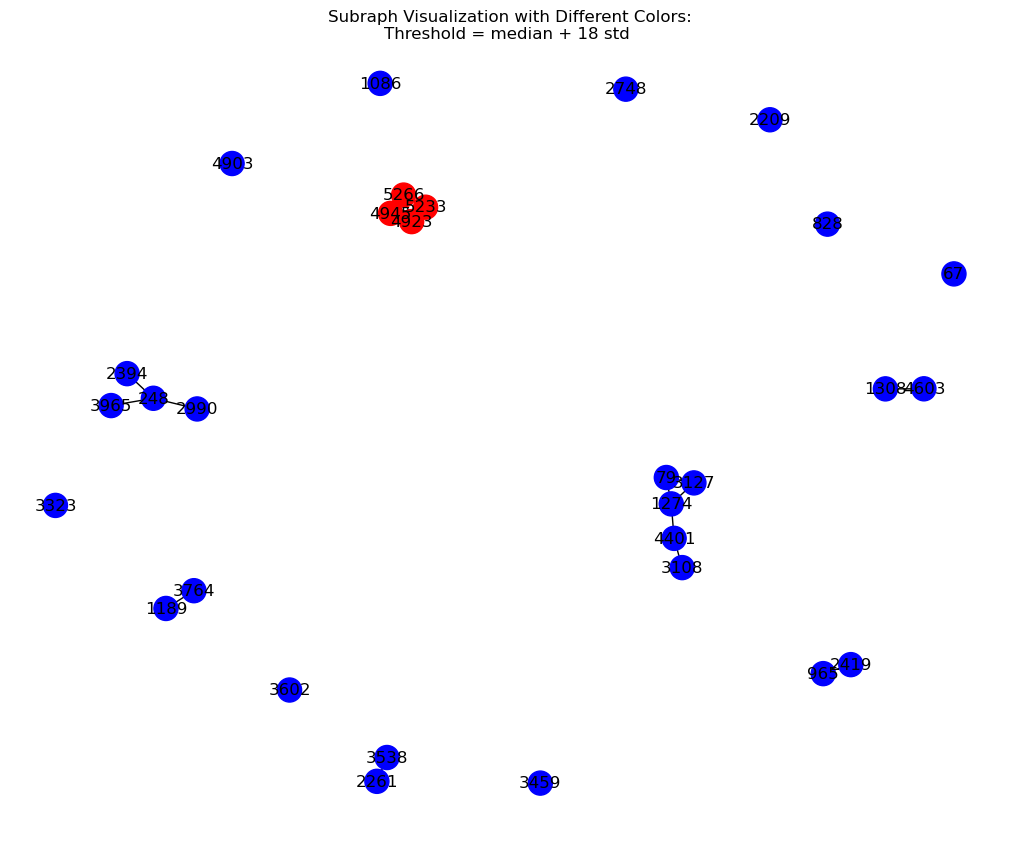

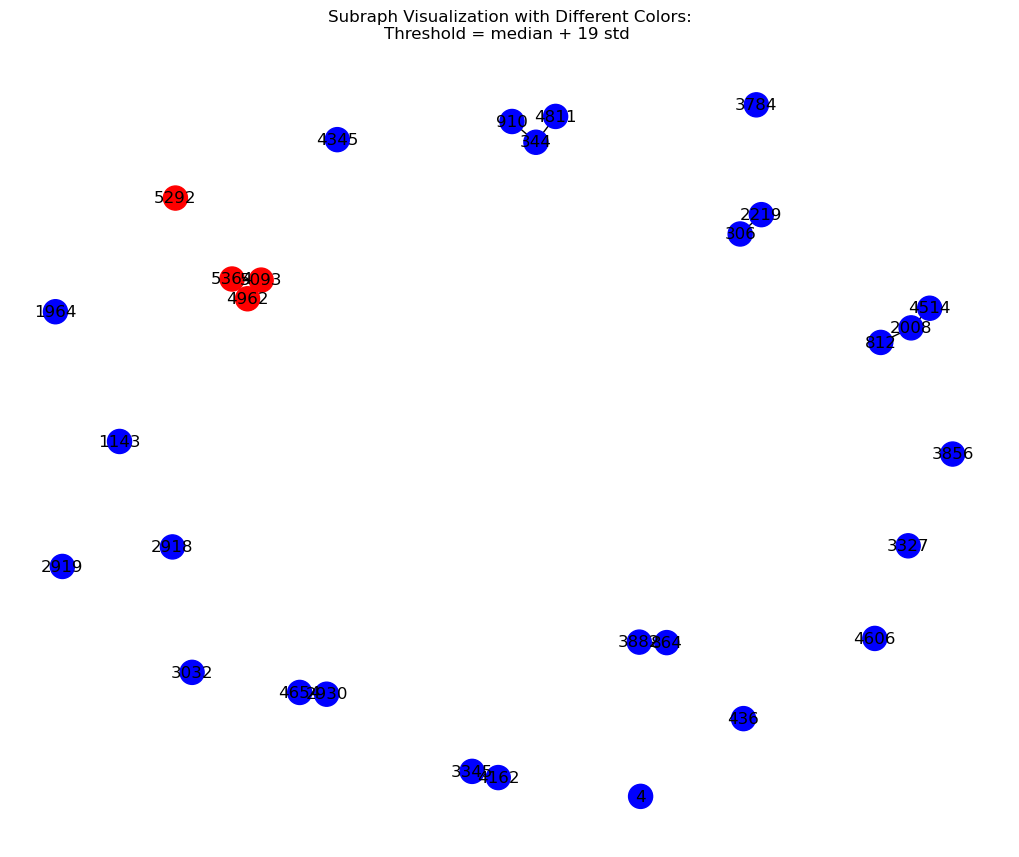

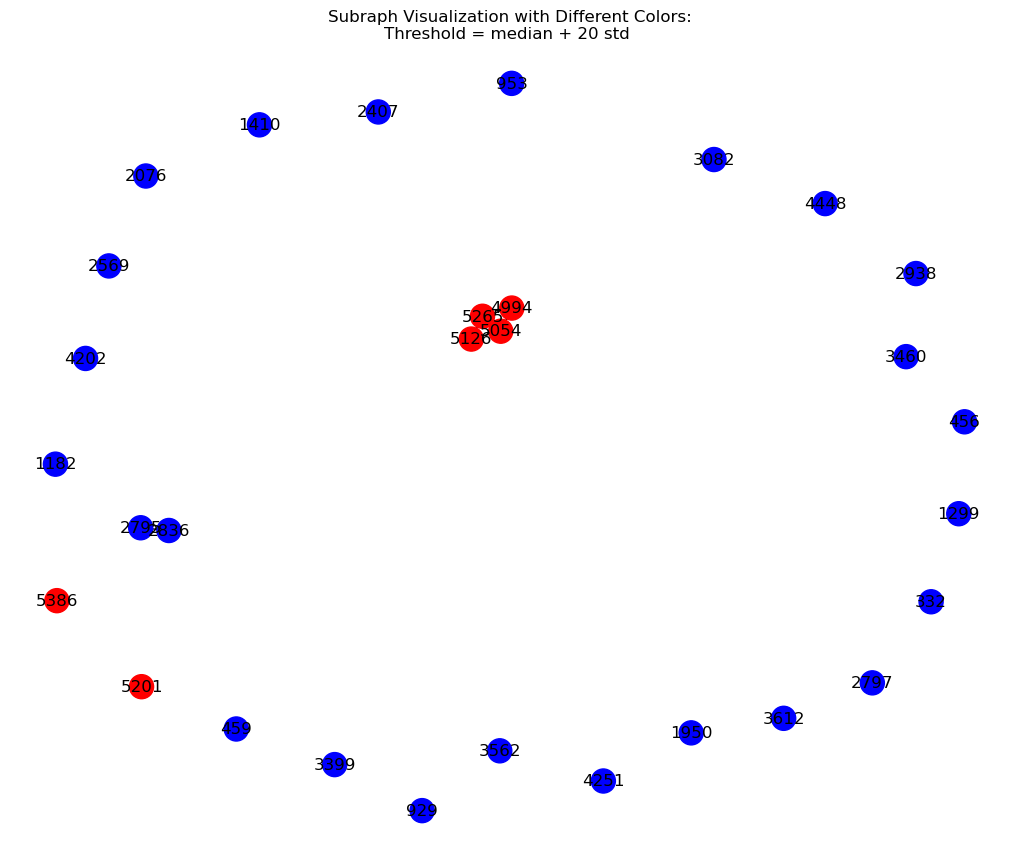

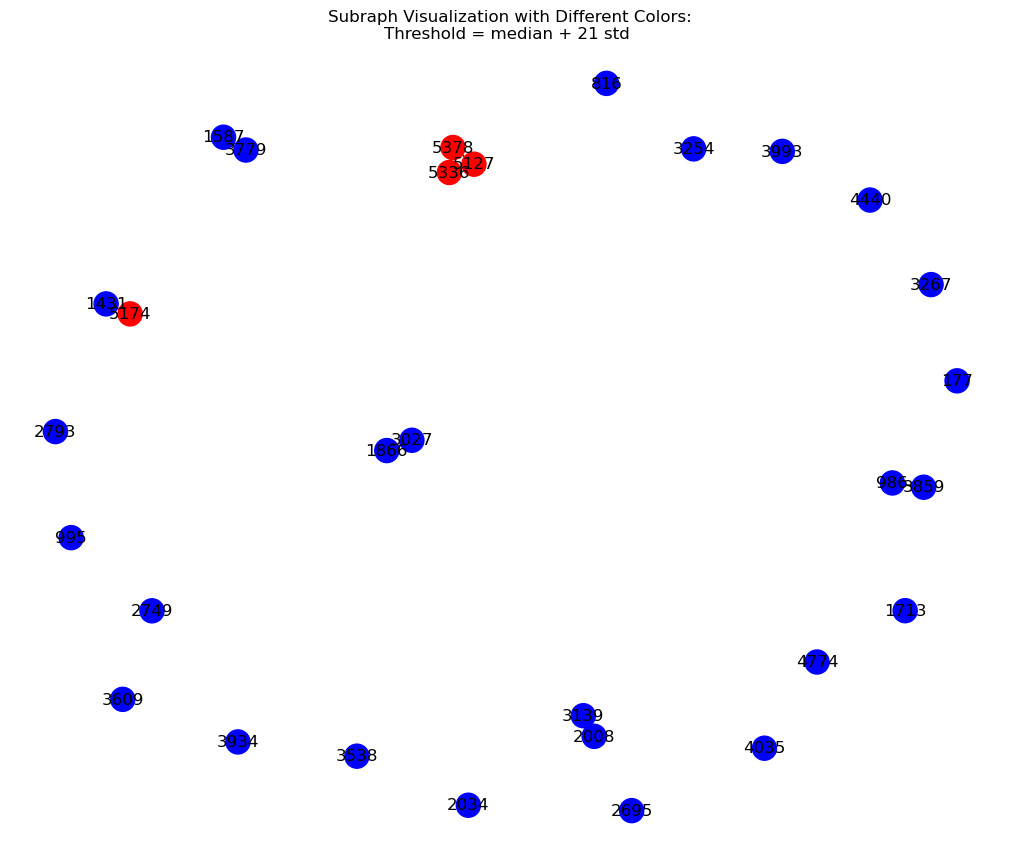

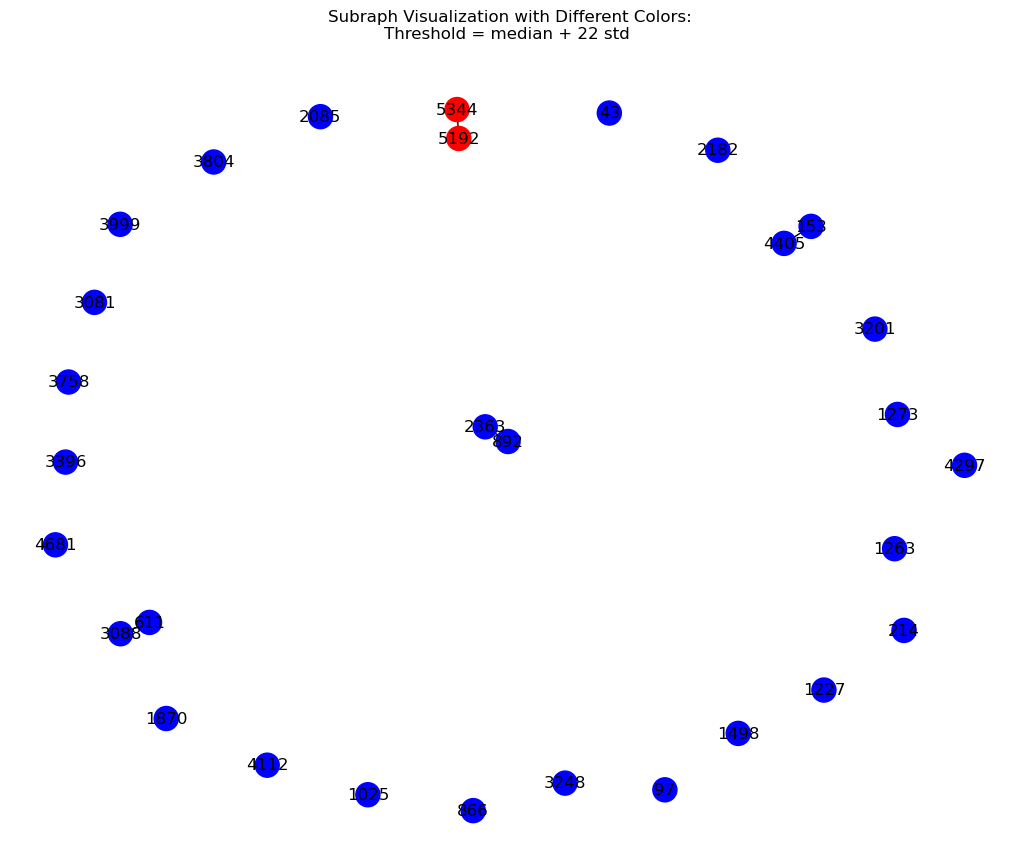

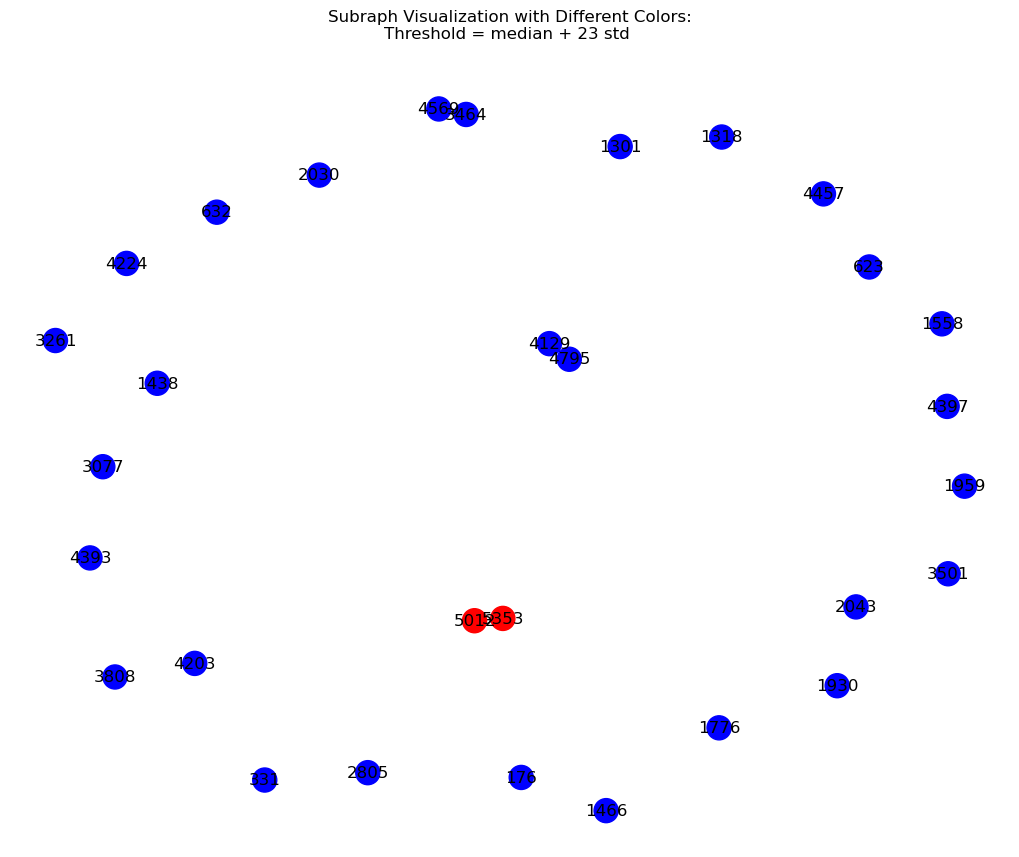

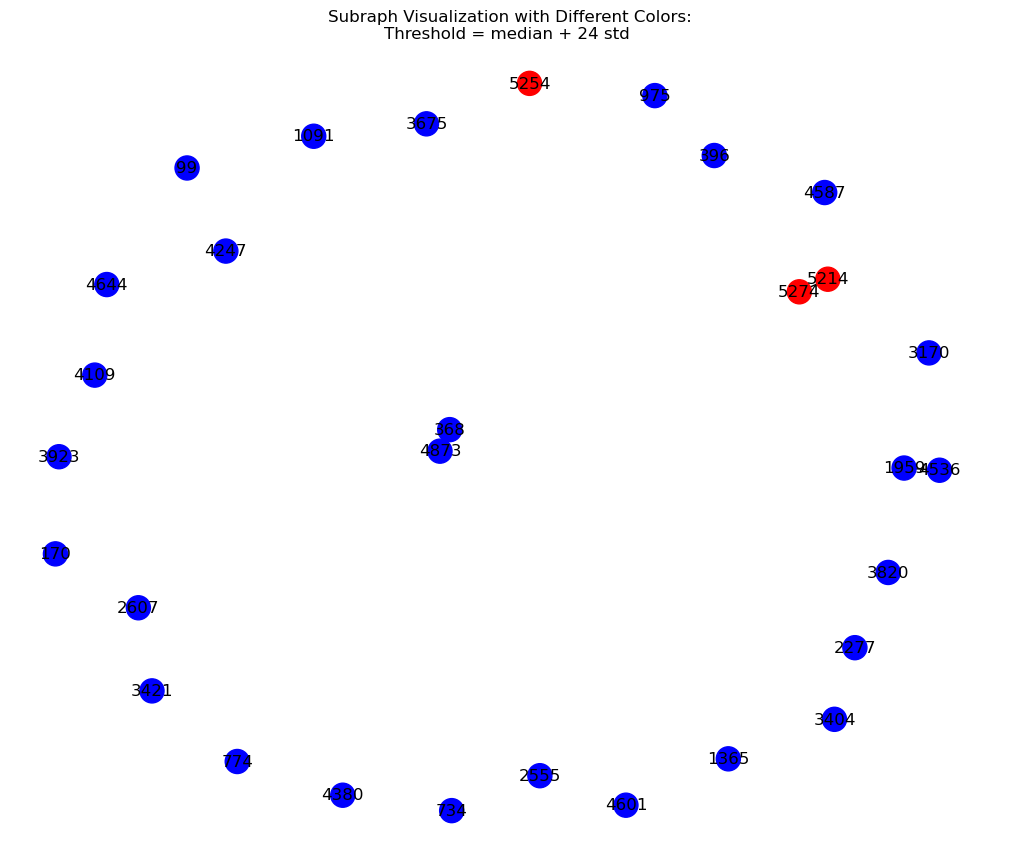

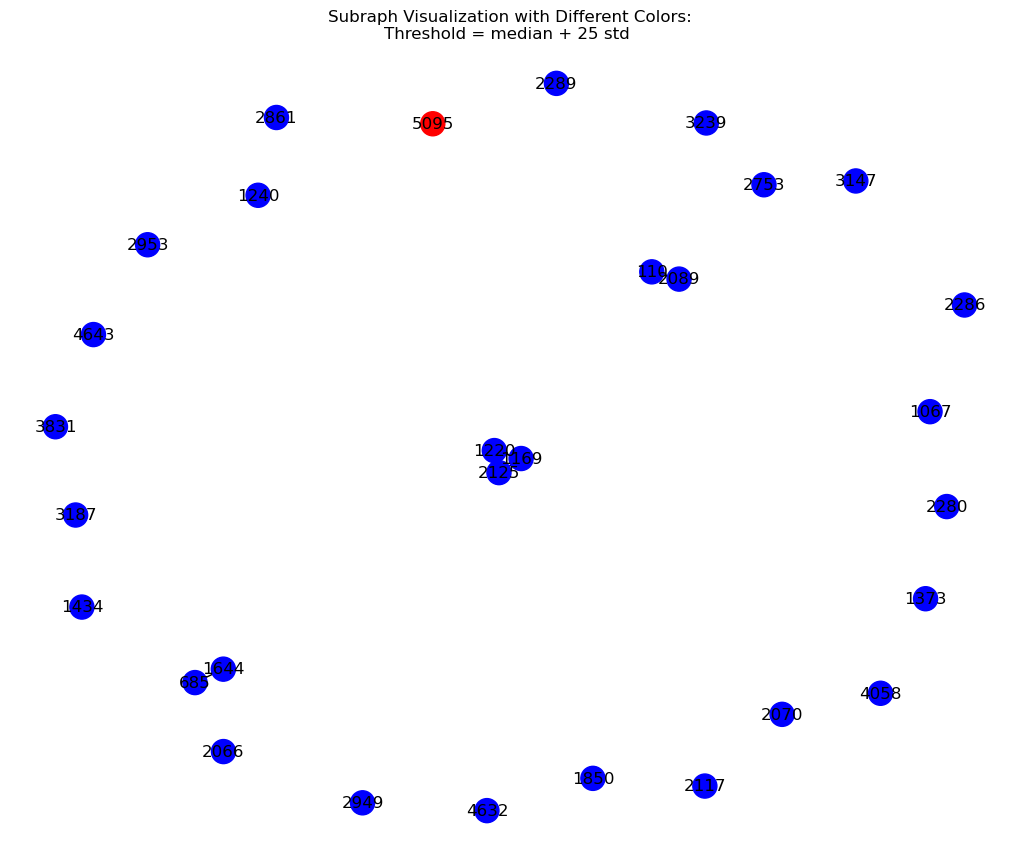

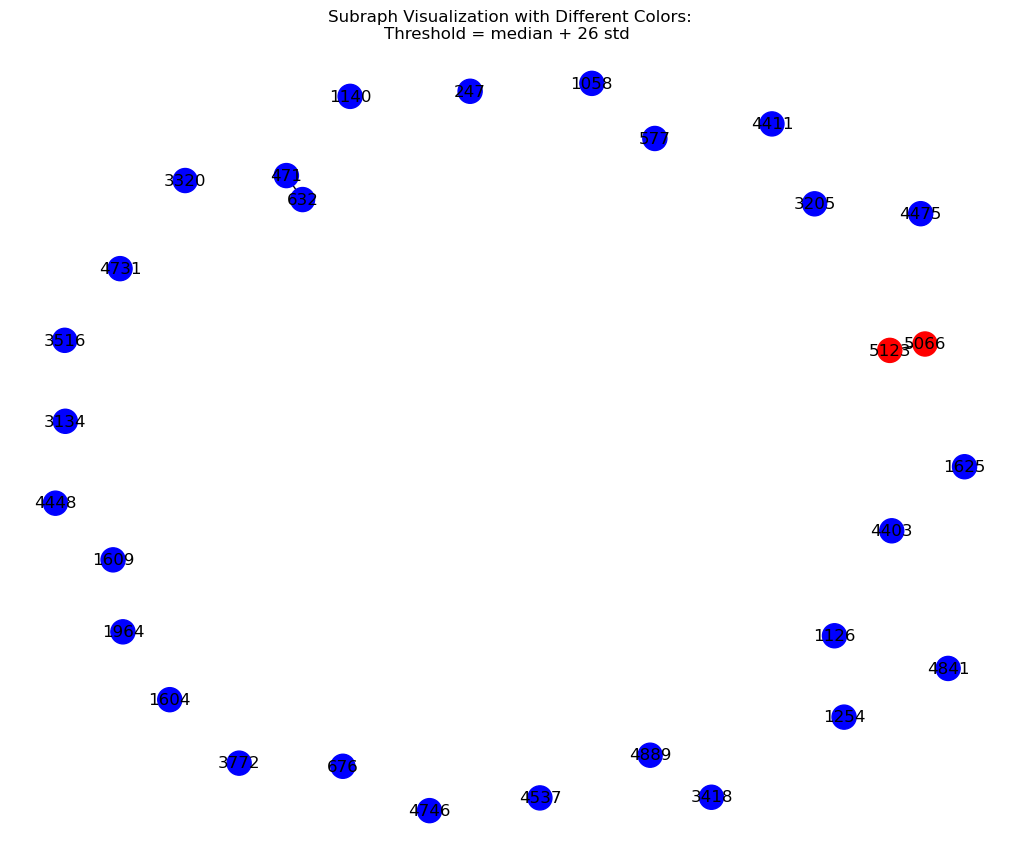

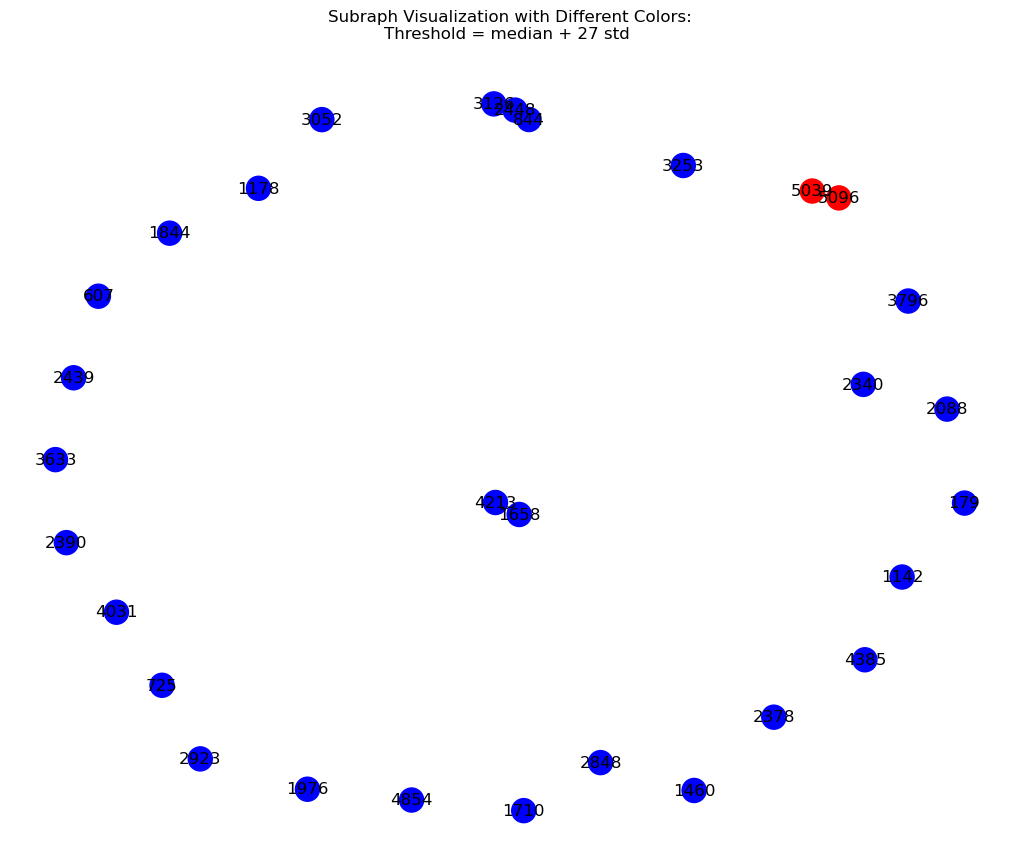

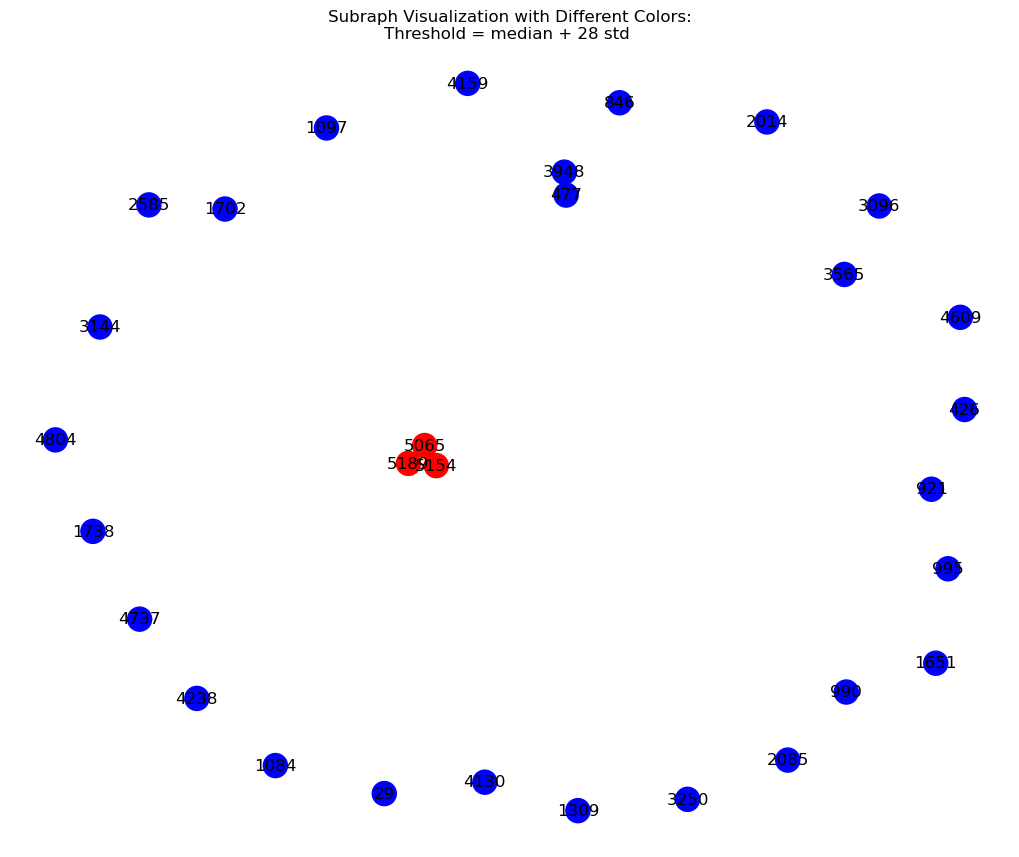

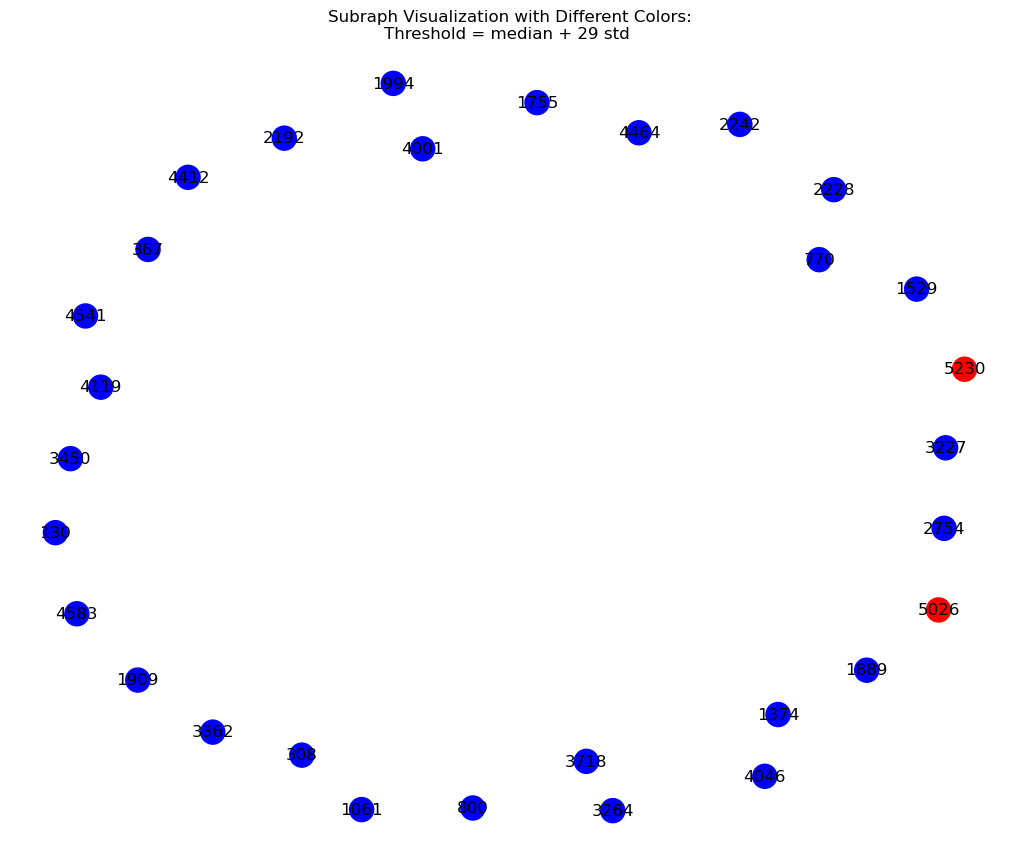

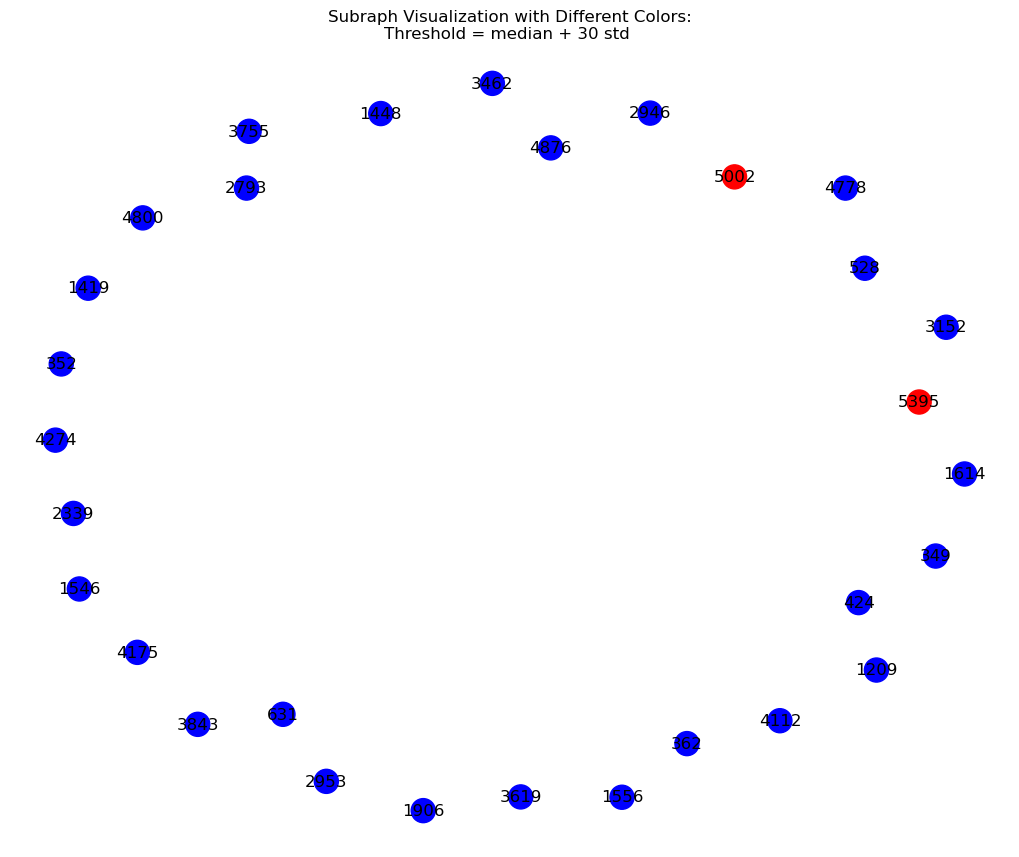

In [72]:
# 圖
import matplotlib.pyplot as plt
import random
for idx,G in tqdm(enumerate(graph),desc="plot..."):
    subset_nodes = random.sample(G.nodes(), k=30)
    subgraph = G.subgraph(subset_nodes)

    # 定義顏色映射
    color_map = {0: 'blue', 1: 'red'}

    # 根據類別為節點指定顏色
    node_colors = [color_map[G.nodes[node]['Class']] for node in subgraph.nodes()]

    # 繪製子圖
    plt.figure(figsize=(10, 8))
    nx.draw(subgraph, with_labels=True, node_color=node_colors)
    plt.title(f"Subraph Visualization with Different Colors:\nThreshold = median + {idx} std ")
    # 保存图为文件
    plt.savefig(f'./plot_G/median_add_{idx}_std.png')  # 将图保存为 PNG 格式
    # plt.show()

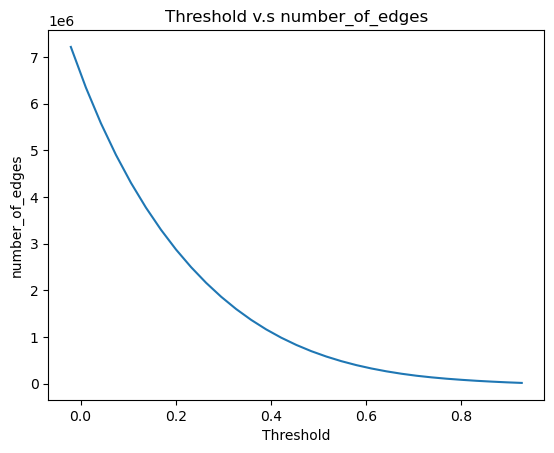

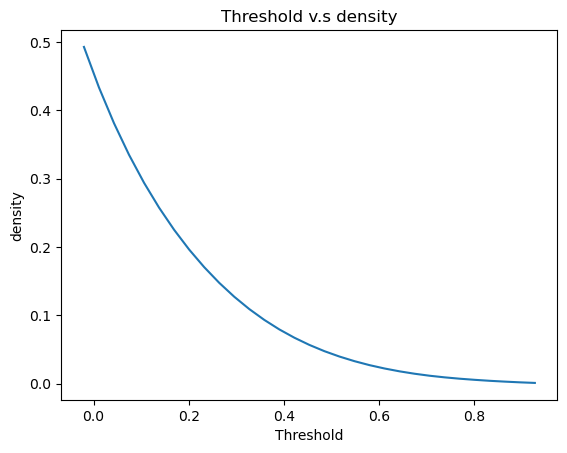

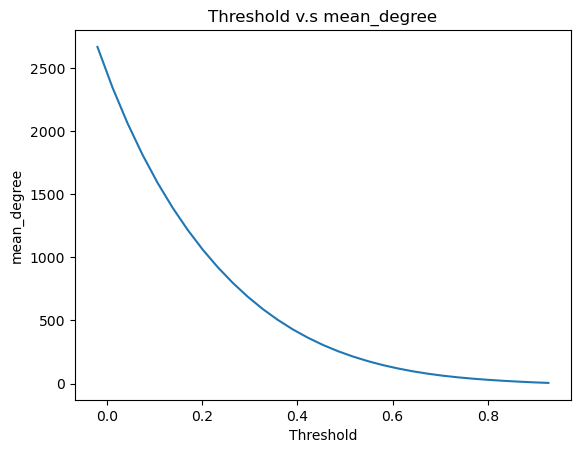

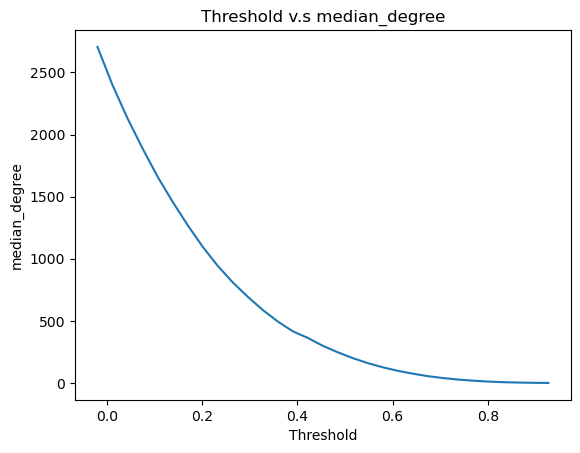

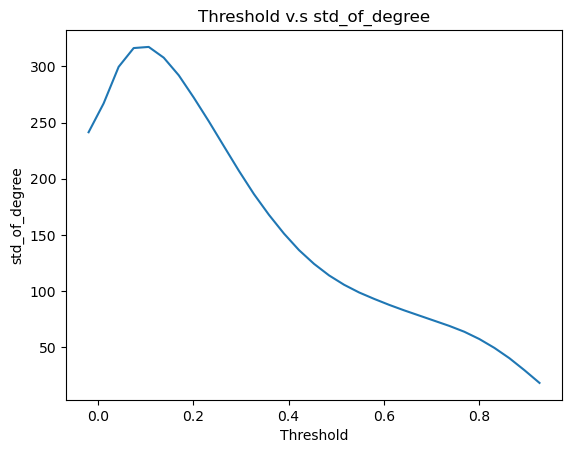

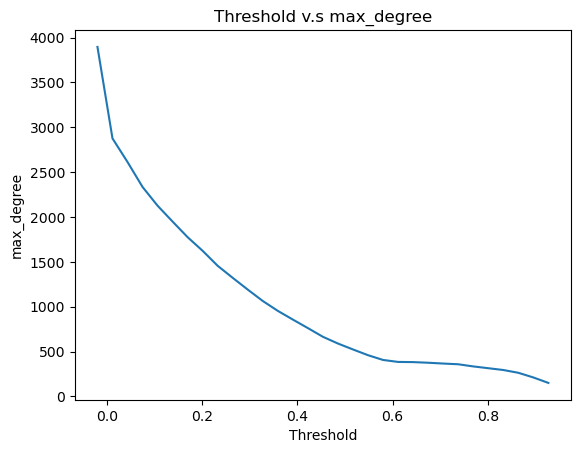

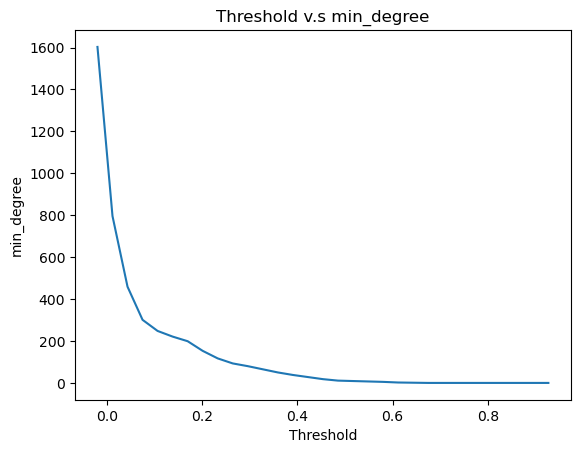

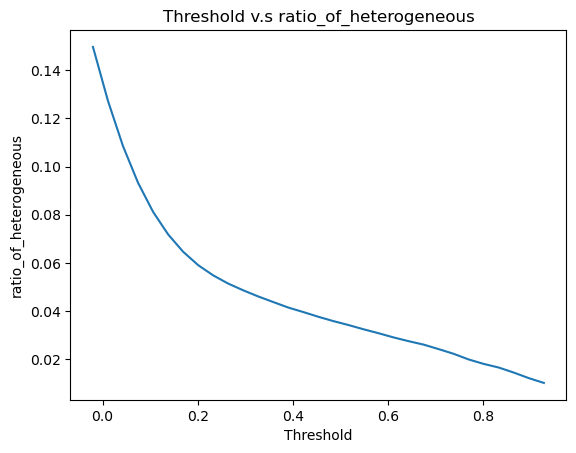

In [73]:
## plot graph construction experiments result
x=data_dic['threshold']
for key in data_dic:
    if key=='graph' or key=='threshold' or key=='number_of_nodes':
        continue
    y=data_dic[key]
    plt.figure()
    plt.plot(x,y)
    plt.title(f"Threshold v.s {key}")
    plt.xlabel("Threshold")
    plt.ylabel(f"{key}")
    plt.savefig(f"./experiments_plt/threshold_vs_{key}")
    plt.show()
    
    

In [74]:
# node_features = {node: data for node, data in G.nodes(data=True)}
# print(node_features[0])
# print(list(node_features[0].values()))

In [112]:
# 讀所有graph
folder_path = './graph/'
graph = {}
# 遍歷資料夾下的所有檔案
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    # print(file_path)
    # 檢查是否是.pkl檔案
    if filename.endswith(".pickle"):
        # 讀取.pkl檔案
        try:
            with open(file_path, "rb") as file:
                G = pickle.load(file)
                # 在這裡可以對讀取的資料進行處理
                print(f"從 '{file_path}' 讀取到資料：{G}")
                threshold = float(os.path.splitext(filename)[0])
                graph[threshold] = G
        except Exception as e:
            print(f"讀取 '{file_path}' 時發生錯誤：{e}")


從 './graph/0.8958070223397055.pickle' 讀取到資料：Graph with 5412 nodes and 27601 edges
從 './graph/0.23234439290589237.pickle' 讀取到資料：Graph with 5412 nodes and 2495539 edges
從 './graph/0.832620105250771.pickle' 讀取到資料：Graph with 5412 nodes and 60284 edges
從 './graph/0.13756401727249049.pickle' 讀取到資料：Graph with 5412 nodes and 3769543 edges
從 './graph/0.5798724368950327.pickle' 讀取到資料：Graph with 5412 nodes and 395915 edges
從 './graph/0.04278364163908861.pickle' 讀取到資料：Graph with 5412 nodes and 5579009 edges
從 './graph/0.6430593539839672.pickle' 讀取到資料：Graph with 5412 nodes and 263023 edges
從 './graph/0.6114658954394999.pickle' 讀取到資料：Graph with 5412 nodes and 324153 edges
從 './graph/0.7062462710729018.pickle' 讀取到資料：Graph with 5412 nodes and 168895 edges
從 './graph/0.7378397296173691.pickle' 讀取到資料：Graph with 5412 nodes and 134227 edges
從 './graph/0.26393785145035964.pickle' 讀取到資料：Graph with 5412 nodes and 2159647 edges
從 './graph/0.45349860271716347.pickle' 讀取到資料：Graph with 5412 nodes and 829075 edge

In [113]:
print(graph)

{0.8958070223397055: <networkx.classes.graph.Graph object at 0x7f7c69e43910>, 0.23234439290589237: <networkx.classes.graph.Graph object at 0x7f7fb7574910>, 0.832620105250771: <networkx.classes.graph.Graph object at 0x7f7fb7574640>, 0.13756401727249049: <networkx.classes.graph.Graph object at 0x7f7fb7574a30>, 0.5798724368950327: <networkx.classes.graph.Graph object at 0x7f80a9736910>, 0.04278364163908861: <networkx.classes.graph.Graph object at 0x7f80a9736b50>, 0.6430593539839672: <networkx.classes.graph.Graph object at 0x7f80f81923a0>, 0.6114658954394999: <networkx.classes.graph.Graph object at 0x7f7d1ac65880>, 0.7062462710729018: <networkx.classes.graph.Graph object at 0x7f7d1ac65520>, 0.7378397296173691: <networkx.classes.graph.Graph object at 0x7f7e5d7d4a90>, 0.26393785145035964: <networkx.classes.graph.Graph object at 0x7f7fb7f835e0>, 0.45349860271716347: <networkx.classes.graph.Graph object at 0x7f7fb7519430>, 0.3903116856282288: <networkx.classes.graph.Graph object at 0x7f7fb7519

In [121]:
# networkx graph 轉pytorch Data
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GATConv


all_data = []
for threshold in tqdm(sorted(graph.keys())):
    G = graph[threshold]
    x, y, edge_index = [], [], []
    for node in G.nodes():
        x.append(list(G.nodes[node].values())[:-1])
        y.append(list(G.nodes[node].values())[-1])

    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.long)
    edge_index = torch.tensor(list(G.edges)).t().contiguous()

    data = Data(x=x, edge_index=edge_index, y=y)
    data['threshold'] = threshold
    all_data.append(data)

  0%|          | 0/31 [00:00<?, ?it/s]/tmp/ipykernel_70787/2119178696.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(y, dtype=torch.long)
100%|██████████| 31/31 [00:27<00:00,  1.15it/s]


In [122]:
print(all_data)

[Data(x=[5412, 30], edge_index=[2, 7214068], y=[5412], threshold=-0.020403275449845982), Data(x=[5412, 30], edge_index=[2, 6344668], y=[5412], threshold=0.011190183094621314), Data(x=[5412, 30], edge_index=[2, 5579009], y=[5412], threshold=0.04278364163908861), Data(x=[5412, 30], edge_index=[2, 4902005], y=[5412], threshold=0.07437710018355591), Data(x=[5412, 30], edge_index=[2, 4301888], y=[5412], threshold=0.1059705587280232), Data(x=[5412, 30], edge_index=[2, 3769543], y=[5412], threshold=0.13756401727249049), Data(x=[5412, 30], edge_index=[2, 3295381], y=[5412], threshold=0.16915747581695778), Data(x=[5412, 30], edge_index=[2, 2871974], y=[5412], threshold=0.20075093436142508), Data(x=[5412, 30], edge_index=[2, 2495539], y=[5412], threshold=0.23234439290589237), Data(x=[5412, 30], edge_index=[2, 2159647], y=[5412], threshold=0.26393785145035964), Data(x=[5412, 30], edge_index=[2, 1861323], y=[5412], threshold=0.29553130999482696), Data(x=[5412, 30], edge_index=[2, 1597259], y=[5412

In [123]:
# gat
from torch_geometric.nn import GATConv
import torch.nn.functional as F
class Encoder_GAT(torch.nn.Module):
    def __init__(self, num_heads, input_dim, hidden_dim, output_dim, num_layers):
        super(Encoder_GAT, self).__init__()
        self.num_layers = num_layers
        self.convs = torch.nn.ModuleList()
        for i in range(self.num_layers-1):
            if i:
                conv = GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads)
            else:
                conv = GATConv(input_dim, hidden_dim, heads=num_heads)

            self.convs.append(conv)
            
        if self.num_layers ==1:
            conv = GATConv(input_dim, output_dim)
            self.convs.append(conv)
        elif self.num_layers >1:
            conv = GATConv(hidden_dim * num_heads, output_dim)
            self.convs.append(conv)

    def forward(self, x, edge_index):
        xs = []
        for i in range(self.num_layers):
            x = F.relu(self.convs[i](x, edge_index))
        return x

In [124]:
# model (gat + linear)
import torch.nn as nn
import torch.nn.functional as F
class myGNN(nn.Module):
    def __init__(self, enc_num_heads, enc_input_dim, enc_hidden_dim, enc_num_layers, linear_output_dim):
        super(myGNN, self).__init__()
        # GAT(input、output大小一樣)
        self.encoder_neighbor = Encoder_GAT(enc_num_heads, enc_input_dim, enc_hidden_dim, enc_input_dim, enc_num_layers)
        # linear層
        self.proj_head_neighbor = nn.Linear(enc_input_dim, linear_output_dim)
        self.proj_head_ego = nn.Linear(enc_input_dim, linear_output_dim)

        self.init_emb()
    # embedding初始化
    def init_emb(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight.data)
                # BIASE初始化為0
                if m.bias is not None:
                    m.bias.data.fill_(0.0)
    @staticmethod
    def negative_sample(h_ego, h_neighbor):
        # 返回一个0~n-1的数组，随机打散的
        perm = torch.randperm(h_ego.shape[0])
        # 打亂，作ego-ego negative
        h_ego_neg = h_ego[perm]
        # 打亂，作ego-neigbor negative
        h_neighbor_neg = h_neighbor[perm]
        return h_ego_neg, h_neighbor_neg

    # @staticmethod
    # def cosine_similarity(x1, x2):
    #     return torch.div(torch.sum(x1 * x2,0),torch.sqrt(torch.sum(torch.pow(x1,2),0))* torch.sqrt(torch.sum(torch.pow(x2,2),0))).item()

    @staticmethod
    def discriminator(x1, x2):
        return -1 * F.cosine_similarity(x1, x2, dim=1).unsqueeze(0)

    def forward(self, x, edge_index):
        # GAT
        h_neighbor = self.encoder_neighbor(x, edge_index)
        h_neighbor = self.proj_head_neighbor(h_neighbor)
        # linear
        h_ego = self.proj_head_ego(x)

        return h_ego, h_neighbor

In [125]:
# train & eval model
import time
from sklearn.metrics import roc_auc_score
import json
import copy
import os
import numpy as np
import torch

def rescale(x):
    return ((x + 1) / 2)*(1-(2e-06)) + 1e-06


def train_model(args, data, model, optimizer, loss_function):
    stats = {
        "best_loss": 1e9,
        "best_epoch": -1,
    }
    model.train()

    label_ones =  torch.ones(1, data.x.shape[0]).to(args["device"])
    label_zeros = torch.zeros(1, data.x.shape[0]).to(args["device"])

    for epoch in tqdm(range(args['num_epoch'])):
        optimizer.zero_grad()
        data = data.to(args['device'])
        # forward(gat+linear)
        h_ego, h_neighbor = model(data.x, data.edge_index)
        h_ego_neg, h_neighbor_neg  = model.negative_sample(h_ego, h_neighbor)
        # 算 -c
        c_neighbor_pos = model.discriminator(h_ego, h_neighbor)
        c_neighbor_neg = model.discriminator(h_ego, h_neighbor_neg)
        c_ego_neg = model.discriminator(h_ego, h_ego_neg)
        # rescal(x) = (x-(-1)) / 2，使介於0~1(原介於-1~1)
        score_pos = rescale(c_neighbor_pos)
        score_aug = rescale(c_neighbor_neg)
        score_nod = rescale(c_ego_neg)
        
        # BCE loss
        # ego-neighbor postive, ego-neighbor negative, ego-ego negative
        loss_pos = loss_function(score_pos, label_zeros)
        loss_aug = loss_function(score_aug, label_ones)
        loss_nod = loss_function(score_nod, label_ones)
        
        loss_sum = loss_pos \
              + args['alpha'] * loss_aug \
              + args['gamma'] * loss_nod

        loss_sum.backward()
        # 只用postive判斷好壞
        if loss_pos < stats["best_loss"]:
            stats["best_loss"] = loss_pos.item()
            stats["best_epoch"] = epoch
            torch.save(model.state_dict(), args['state_path'])
        optimizer.step()

        # if epoch % 100 ==0:
        #     eval_model(args, data, model)


    return stats

def eval_model(args, data, model):
    model.eval()
    with torch.no_grad():
        data = data.to(args["device"])
        h_ego, h_neighbor = model(data.x, data.edge_index)
        c_neighbor_pos = model.discriminator(h_ego, h_neighbor)
        
        y_true = (data.y).detach().cpu().tolist()
        y_score = c_neighbor_pos.squeeze().detach().cpu().tolist()
        auc = roc_auc_score(y_true, y_score)
        print("auc: ",  auc)
    return auc


In [126]:
# run
import random

def set_random_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def run_experiment(args, data):
    set_random_seeds(args['seed'])
    # Create model
    model = myGNN(args['enc_num_heads'], args['enc_input_dim'], args['enc_hidden_dim'],  args['enc_num_layers'], args["linear_output_dim"])
    model.to(args['device'])
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=args['lr'],
                                 weight_decay=args['weight_decay'])
    loss_function = torch.nn.BCELoss()
    # train
    stats = train_model(
        args, data, model, optimizer, loss_function
    )
    # eval
    model.load_state_dict(torch.load(args["state_path"]))
    auc = eval_model(args, data, model)
    stats["AUC"] = auc

    return model, stats

In [127]:
# 參數
args = {"lr": 5e-4, 
        "alpha": 0.3, 
        "gamma": 0.4, 
        "state_path": "model.pkl", 
        "device": "cuda:0", 
        "seed": 1, 
        "num_epoch": 1500, 
        "weight_decay": 0.0, 
        "enc_num_heads": 3, 
        "enc_input_dim":all_data[0].x.shape[1], 
        "enc_hidden_dim": 32, 
        "linear_output_dim": 64,
        "enc_num_layers":1,
       }

In [129]:
auc_dict = {}
for data in all_data: 
    print("----------threshod = "+str(data.threshold)+"-----------------")
    model, stats = run_experiment(args, data)
    auc_dict[data.threshold]= stats["AUC"]

----------threshod = -0.020403275449845982-----------------


100%|██████████| 1500/1500 [00:42<00:00, 35.37it/s]


auc:  0.6498946559587547
----------threshod = 0.011190183094621314-----------------


100%|██████████| 1500/1500 [00:38<00:00, 39.29it/s]


auc:  0.6070190115010906
----------threshod = 0.04278364163908861-----------------


100%|██████████| 1500/1500 [00:34<00:00, 43.04it/s]


auc:  0.6602565850353626
----------threshod = 0.07437710018355591-----------------


100%|██████████| 1500/1500 [00:32<00:00, 46.55it/s]


auc:  0.7321997488267565
----------threshod = 0.1059705587280232-----------------


100%|██████████| 1500/1500 [00:29<00:00, 51.51it/s]


auc:  0.8055237457862382
----------threshod = 0.13756401727249049-----------------


100%|██████████| 1500/1500 [00:26<00:00, 55.90it/s]


auc:  0.8237509501619406
----------threshod = 0.16915747581695778-----------------


100%|██████████| 1500/1500 [00:24<00:00, 61.21it/s]


auc:  0.8259633815850355
----------threshod = 0.20075093436142508-----------------


100%|██████████| 1500/1500 [00:22<00:00, 66.71it/s]


auc:  0.8262794137087712
----------threshod = 0.23234439290589237-----------------


100%|██████████| 1500/1500 [00:20<00:00, 71.67it/s]


auc:  0.8085200608103643
----------threshod = 0.26393785145035964-----------------


100%|██████████| 1500/1500 [00:19<00:00, 77.61it/s]


auc:  0.7925044616299822
----------threshod = 0.29553130999482696-----------------


100%|██████████| 1500/1500 [00:17<00:00, 83.94it/s]


auc:  0.7839439156586688
----------threshod = 0.3271247685392943-----------------


100%|██████████| 1500/1500 [00:14<00:00, 106.12it/s]


auc:  0.755094933571287
----------threshod = 0.35871822708376155-----------------


100%|██████████| 1500/1500 [00:15<00:00, 97.68it/s]


auc:  0.7364820873818494
----------threshod = 0.3903116856282288-----------------


100%|██████████| 1500/1500 [00:14<00:00, 103.19it/s]


auc:  0.7143032421177871
----------threshod = 0.42190514417269614-----------------


100%|██████████| 1500/1500 [00:13<00:00, 109.33it/s]


auc:  0.6936795640822262
----------threshod = 0.45349860271716347-----------------


100%|██████████| 1500/1500 [00:13<00:00, 114.92it/s]


auc:  0.6808408106946923
----------threshod = 0.48509206126163074-----------------


100%|██████████| 1500/1500 [00:12<00:00, 119.88it/s]


auc:  0.6700172268490978
----------threshod = 0.516685519806098-----------------


100%|██████████| 1500/1500 [00:12<00:00, 124.48it/s]


auc:  0.662792691189107
----------threshod = 0.5482789783505653-----------------


100%|██████████| 1500/1500 [00:11<00:00, 128.94it/s]


auc:  0.6613728187586754
----------threshod = 0.5798724368950327-----------------


100%|██████████| 1500/1500 [00:11<00:00, 129.65it/s]


auc:  0.6469861276356665
----------threshod = 0.6114658954394999-----------------


100%|██████████| 1500/1500 [00:11<00:00, 132.29it/s]


auc:  0.6452655082953269
----------threshod = 0.6430593539839672-----------------


100%|██████████| 1500/1500 [00:11<00:00, 133.91it/s]


auc:  0.635232004759072
----------threshod = 0.6746528125284346-----------------


100%|██████████| 1500/1500 [00:11<00:00, 133.41it/s]


auc:  0.6430258113556746
----------threshod = 0.7062462710729018-----------------


100%|██████████| 1500/1500 [00:11<00:00, 131.00it/s]


auc:  0.6564664716769119
----------threshod = 0.7378397296173691-----------------


100%|██████████| 1500/1500 [00:11<00:00, 131.40it/s]


auc:  0.6552884774274572
----------threshod = 0.7694331881618364-----------------


100%|██████████| 1500/1500 [00:11<00:00, 132.40it/s]


auc:  0.6522074740564479
----------threshod = 0.8010266467063036-----------------


100%|██████████| 1500/1500 [00:11<00:00, 132.77it/s]


auc:  0.6644684876726816
----------threshod = 0.832620105250771-----------------


100%|██████████| 1500/1500 [00:11<00:00, 133.05it/s]


auc:  0.6958215595875471
----------threshod = 0.8642135637952383-----------------


100%|██████████| 1500/1500 [00:11<00:00, 132.89it/s]


auc:  0.7535459630510939
----------threshod = 0.8958070223397055-----------------


100%|██████████| 1500/1500 [00:11<00:00, 131.90it/s]


auc:  0.7915179456672616
----------threshod = 0.9274004808841729-----------------


100%|██████████| 1500/1500 [00:11<00:00, 132.58it/s]

auc:  0.8205412618150572


In [134]:
# 使用sorted函數對字典的值進行降序排列

sorted_dict = dict(sorted(auc_dict.items(), key=lambda item: item[1], reverse=True))

# 輸出排序後的字典
print(sorted_dict)

{0.20075093436142508: 0.8262794137087712, 0.16915747581695778: 0.8259633815850355, 0.13756401727249049: 0.8237509501619406, 0.9274004808841729: 0.8205412618150572, 0.23234439290589237: 0.8085200608103643, 0.1059705587280232: 0.8055237457862382, 0.26393785145035964: 0.7925044616299822, 0.8958070223397055: 0.7915179456672616, 0.29553130999482696: 0.7839439156586688, 0.3271247685392943: 0.755094933571287, 0.8642135637952383: 0.7535459630510939, 0.35871822708376155: 0.7364820873818494, 0.07437710018355591: 0.7321997488267565, 0.3903116856282288: 0.7143032421177871, 0.832620105250771: 0.6958215595875471, 0.42190514417269614: 0.6936795640822262, 0.45349860271716347: 0.6808408106946923, 0.48509206126163074: 0.6700172268490978, 0.8010266467063036: 0.6644684876726816, 0.516685519806098: 0.662792691189107, 0.5482789783505653: 0.6613728187586754, 0.04278364163908861: 0.6602565850353626, 0.7062462710729018: 0.6564664716769119, 0.7378397296173691: 0.6552884774274572, 0.7694331881618364: 0.652207474